<a href="https://colab.research.google.com/github/mrmaggoo1/MAE-494/blob/main/Project1_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Introduction

This discussion pertains to a simplified formulation for autonomous control of a helicopter, particularly during the landing phase. The helicopter's state, denoted as $\textbf{x}(t)$, includes key attributes such as its position in the horizontal plane ($x(t)$ and $y(t)$), velocities along the $x$ and $y$ axes ($\dot{x}(t)$ and $\dot{y}(t)$), and orientation angle ($\theta(t)$), where $t$ denotes time. The control input $\textbf{u}(t)$ for the helicopter comprises two essential parameters: thrust $a(t)$ and angular velocity $\omega(t)$. The dynamics of the helicopter's motion evolve in discrete time steps, as governed by the following equations:

x(t+1) = x(t) + dot_x(t) * Δt + 0.5 * a(t) * sin(θ(t)) * Δt^2

y(t+1) = y(t) + dot_y(t) * Δt + 0.5 * a(t) * cos(θ(t)) * Δt^2

dot_x(t+1) = dot_x(t) + a(t) * sin(θ(t)) * Δt

dot_y(t+1) = dot_y(t) + a(t) * cos(θ(t)) * Δt

θ(t+1) = θ(t) + ω(t) * Δt

Here, $\Delta t$ represents the discrete time interval between steps. The closed-loop controller, which determines $\textbf{u}(t)$, is expressed as:
u(t) = [a(t), ω(t)] = π_w(x(t))

Here, π_w(⋅) is a neural network with learnable parameters $w$ that must be determined through optimization.

A loss function $l(x(t), u(t))$ is defined for each time step. In this instance, we set $l(x(t), u(t)) = 0$ for all $t=1,...,T-1$, where $T$ marks the final time step. The loss at the final time step is determined as:
l(x(T), u(T)) = ||x(T)||^2

The optimization problem is articulated as follows:
Minimize w:
  ||x(T)||^2

Subject to:
  - Helicopter dynamics as described above
  - u(t) = π_w(x(t)) for all t=1,...,T-1

  It's noteworthy that, although this problem includes constraints, the objective function can be expressed as a function of $x(T-1)$ and $u(T-1)$, and $x(T-1)$ can, in turn, be expressed as a function of $x(T-2)$ and $u(T-2)$, and so forth. Thus, from the perspective of parameter optimization, it essentially becomes an unconstrained problem with respect to w.

## 2. Code

In [ ]:
# import all neccessary libraries
import logging
import math
import random
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')
from IPython.display import Image
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

logger = logging.getLogger(__name__)


Set up global constants and environmental controls for the helicopter landing simulation:

In [ ]:
# Environment parameters for Helicopter Control
FRAME_TIME = 0.1  # time interval
GRAVITY = 9.81 # gravity constant in Y direction
THRUST = 15.5 # thrust constant
OMEGA_RATE = 0.5  # max rotation rate

Dynamical Model Setup in PyTorch

In my helicopter control code, I've established the dynamical model using PyTorch to create a differentiable computational graph, allowing seamless integration with the neural network controller. This setup involves several critical components:

delta_state_gravity represents the impact of gravity on the helicopter's state, particularly in the vertical direction. It's defined as [0, 0, 0, -g * Δt, 0].

To construct the state transformation matrix, I use state_tensor, which depends on the helicopter's orientation angle and is given by [0, 0, sin(θ), cos(θ), 0].

delta_state captures the influence of thrust on the state and is calculated as [0, 0, sin(θ) * Δt * THRUST * a(t), cos(θ) * Δt * THRUST * a(t), 0], where a(t) is the acceleration, and THRUST is a scaling factor.

delta_state_theta models the effect of angular velocity and is represented as [0, 0, 0, 0, ω(t) * Δt * omega_rate].

The state at time t+1 is denoted as state, and I perform updates on its first two elements, which correspond to the $x$ and $y$ coordinates. These updates involve matrix operations to account for changes in position, velocity, and orientation:

In [ ]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = Thrust
        action[1] = theta_dot

        state[0] = x
        state[1] = y
        state[2] = vx
        state[3] = vy
        state[4] = theta

        """
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed.

        delta_state_gravity = torch.tensor([[0., 0.,0., -GRAVITY * FRAME_TIME, 0.]])

        state_tensor = torch.zeros((1, 5))
        state_tensor[0, 3] = torch.cos(state[0, 4])
        state_tensor[0, 2] = torch.sin(state[0, 4])

        delta_state = THRUST * FRAME_TIME * torch.mul(state_tensor, action[0, 0].reshape(-1, 1))

        # Theta
        delta_state_theta = FRAME_TIME * OMEGA_RATE * torch.mul(torch.tensor([0., 0., 0., 0, 1.]),action[0, 1].reshape(-1, 1))

        # Update state
        step_mat = torch.tensor([[1., 0.,FRAME_TIME, 0., 0.],
                                 [0., 1., 0., FRAME_TIME, 0.],
                                 [0., 0., 1., 0., 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])

        shift_mat = torch.tensor([[0., 0.,FRAME_TIME, 0., 0.],
                                 [0., 0., 0., FRAME_TIME, 0.],
                                 [0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0.]])

        state = torch.matmul(step_mat, state.T) + torch.matmul(shift_mat, delta_state.T)  * 0.5 + torch.matmul(shift_mat, delta_state_gravity.T)  * 0.5
        state = state.T

        state = state + delta_state  + delta_state_gravity + delta_state_theta

        return state

The architecture of this controller network includes two hidden layers with hyperbolic tangent (Tanh) activation functions. For the output layer, I use a sigmoid activation function to ensure that the two output values are constrained within the range of 0 to 1.

To align the network's output with the desired action ranges, I apply linear transformations. I scale the first output variable (representing thrust) to fall within the range of 0 to 2, allowing precise control over the propulsion force. The second output variable (representing angular velocity) is adjusted to be in the range of -1 to 1, enabling the helicopter to tilt in both directions

In [ ]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden:
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())


    def forward(self, state):
        action = self.network(state)
        action = (action - torch.tensor([0., 0.5]))*2  # bound theta_dot range -1 to 1
        return action

Simulating Helicopter Hovering: With the dynamical model and controller in place, I've simulated and controled the helicopter's descent. I initialized the helicopter at an altitude of 100 meters with an initial state of $[0, 100, 0, 0, 0]$. I obtained control actions using action = self.controller(state) and update the state using state = self.dynamics(state, action). This iterative process continues for T time steps, after which I evaluated the performance by computing the error to be minimized through controller weight adjustments.

Controller Versatility for Multiple Initial States: The current controller is tailored to a specific initial state. However, it's practical to design a controller that can accommodate a range of initial conditions. This can be approximated by optimizing the controller's performance across a batch of initial states, allowing for greater versatility.

Fine-Tuning Control Objectives: Fine-tuning the weights associated with different loss terms is a common practice in controller design. For instance, if it is crucial to achieve a landing with zero vertical velocity, it may be necessary to assign higher weights to terms related to vertical velocity, ensuring that it converges to zero during the descent.

In [ ]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [[5.,100.,0.,0.,-0.75]]
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
        target_position = torch.tensor([10., 10.])  # Set your target position here
        current_position = state[0, :2]  # Extract current x and y position
        position_error = current_position - target_position
        return torch.mean(position_error ** 2)

Gradient-Based Error Minimization: Having constructed the computational graph to minimize the error, I now proceed to calculate the gradient of the error concerning the controller weights. My objective is to minimize the error through the application of gradient-based algorithms, thereby refining the controller's performance.

Choice of Optimization Algorithm: In this context, I have opted for the L-BFGS (Limited-memory Broyden-Fletcher-Goldfarb-Shanno) algorithm. L-BFGS is a quasi-Newton optimization technique that relies on a limited memory of past gradients to approximate the current Hessian matrix. This approach is reminiscent of a first-order Taylor expansion applied to the gradient itself. One crucial advantage of L-BFGS is its ability to ensure a positive definite Hessian approximation, rendering it well-suited for optimizing non-convex problems like helicopter control.

Gradient Descent vs. Newton's Method: While gradient descent remains a valid optimization approach for this task, I must note that Newton's method is not a viable choice due to the non-convex nature of the problem. Therefore, I have opted for L-BFGS, a quasi-Newton method that is particularly well-suited for non-convex optimization challenges, such as those encountered in helicopter control.

Fixed Learning Rate: In this implementation, I have utilized a fixed step size (learning rate) of lr = 0.01. However, I acknowledge that an alternative approach worth considering is the use of adaptive step sizes or line search methods. These techniques have the potential to enhance search efficiency during the optimization process.

In [ ]:
class Optimize:

    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects

    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # define the opmization algorithm
        self.loss_list = []

    # Define loss calculation method for objective function

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()


    # Define training method for the model

    def train(self, epochs):
        # self.optimizer = epoch
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            self.visualize()

        plt.plot(list(range(epochs)), l)

        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        self.animation(epochs)


    # Define result visualization method

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        vx = data[:, 2]
        vy = data[:, 3]
        theta = data[:, 4]
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        thrust = action_data[:,0]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(1, 4, tight_layout = 1, figsize = (15, 5))

        ax[0].plot(x, y, c = 'b')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Y")
        ax[0].set(title=f'Displacement plot(x-y) at frame {self.epoch}')

        ax[1].plot(frame, vx, c = 'c', label = "Velocity in x")
        ax[1].plot(frame, vy, c = 'r', label = "Velocity in y")
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Velocity (m/s)")
        ax[1].legend(frameon=0)
        ax[1].set(title =f'Velocity plot at frame {self.epoch}')

        ax[2].plot(frame, theta, c = 'g', label = "theta")
        ax[2].set_xlabel("Time interval")
        ax[2].set_ylabel("Theta")
        ax[2].legend(frameon=0)
        ax[2].set(title=f'Theta plot at {self.epoch}')

        ax[3].plot(frame, thrust, c = 'y', label = "thrust")
        ax[3].set_xlabel("Time interval")
        ax[3].set_ylabel("Thrust")
        ax[3].legend(frameon=0)
        ax[3].set(title=f'Thrust plot at {self.epoch}')
        plt.show()

    def animation(self, epochs):
              # Size
        length = 0.10          # m
        width = 0.02          # m

        #
        v_exhaust = 1
        print("Generating Animation")
        steps = self.simulation.T + 1
        final_time_step = round(1/steps,2)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])

        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        fig = plt.figure(figsize = (5,8), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        plt.axhline(y=0., color='b', linestyle='--', lw=0.8)

        ln1, = ax1.plot([], [], linewidth = 10, color = 'lightblue') # rocket body
        ln6, = ax1.plot([], [], '--', linewidth = 2, color = 'orange') # trajectory line
        ln2, = ax1.plot([], [], linewidth = 4, color = 'tomato') # thrust line

        plt.tight_layout()

        ax1.set_xlim(-40, 20)
        ax1.set_ylim(0, 110)
        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

        def update(i):
            rocket_theta = x_t[i, 4]

            rocket_x = x_t[i, 0]
            # length/1 is just to make rocket bigger in animation
            rocket_x_points = [rocket_x + length/1 * np.sin(rocket_theta), rocket_x - length/1 * np.sin(rocket_theta)]

            rocket_y = x_t[i, 1]
            rocket_y_points = [rocket_y + length/1 * np.cos(rocket_theta), rocket_y - length/1 * np.cos(rocket_theta)]

            ln1.set_data(rocket_x_points, rocket_y_points)

            thrust_mag = u_t[i, 0]
            thrust_angle = -u_t[i, 1]

            flame_length = (thrust_mag) * (0.4/v_exhaust)
            # flame_x_points = [rocket_x_points[1], rocket_x_points[1] + flame_length * np.sin(thrust_angle - rocket_theta)]
            # flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(thrust_angle - rocket_theta)]
            flame_x_points = [rocket_x_points[1], rocket_x_points[1] - flame_length * np.sin(rocket_theta)]
            flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(rocket_theta)]

            ln2.set_data(flame_x_points, flame_y_points)
            ln6.set_data(x_t[:i, 0], x_t[:i, 1])
            f.value += 1

        playback_speed = 5000 # the higher the slower
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save as GIF
        writer = PillowWriter(fps=20)
        anim.save("Helicopter_hover.gif", writer=writer)

Run code

[1] loss: 44588.895


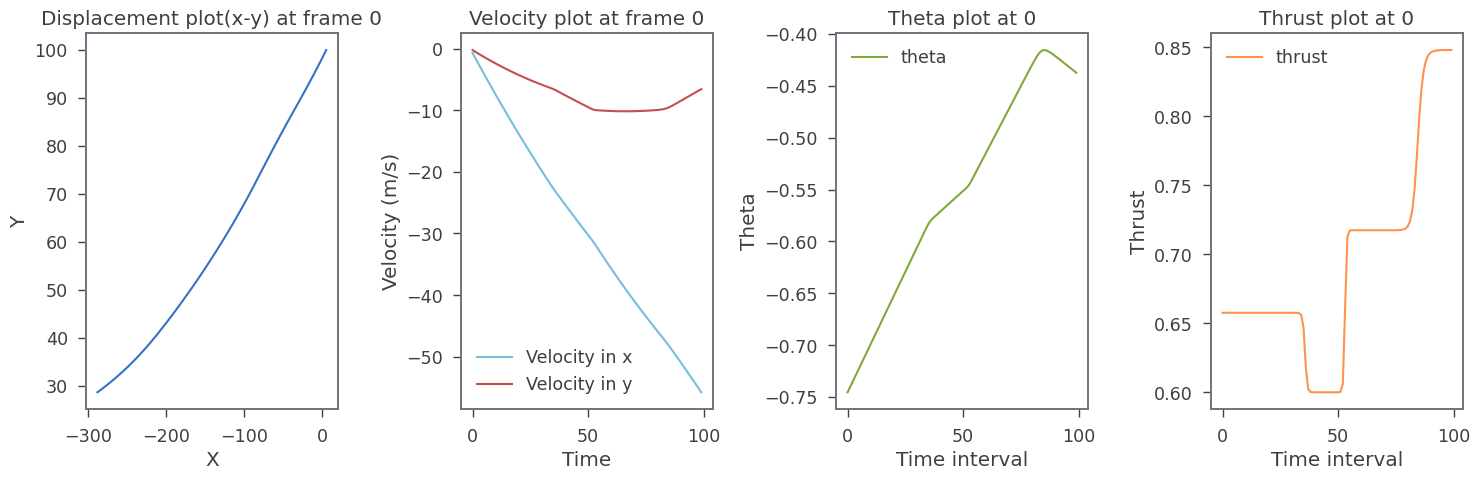

[2] loss: 18797.814


[3] loss: 9552.453


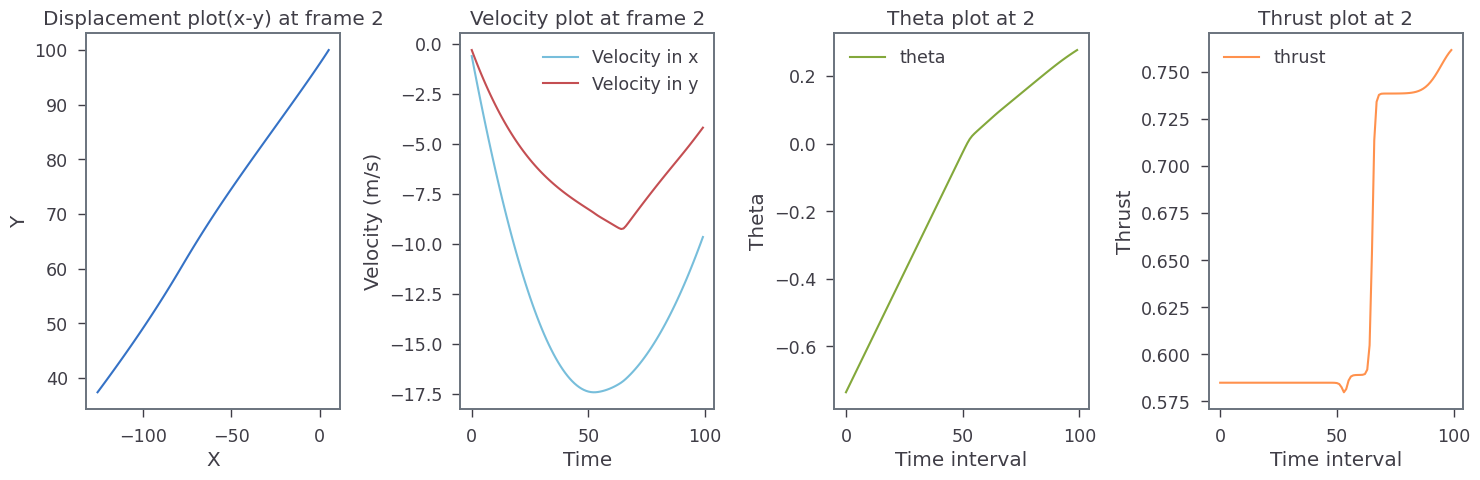

[4] loss: 4720.051


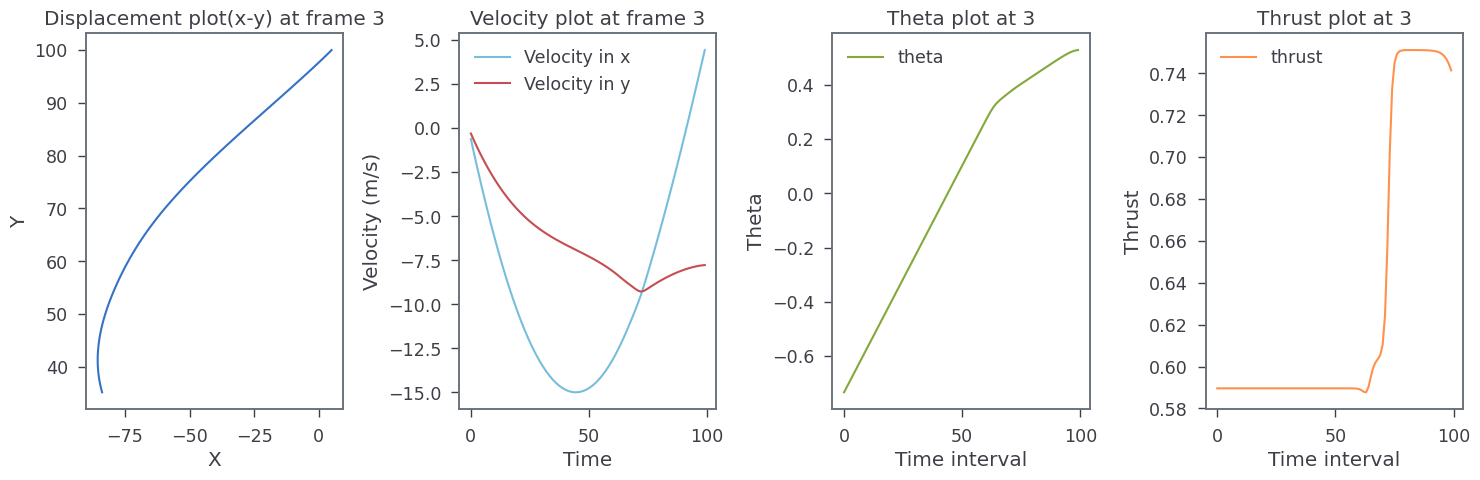

[5] loss: 3047.843


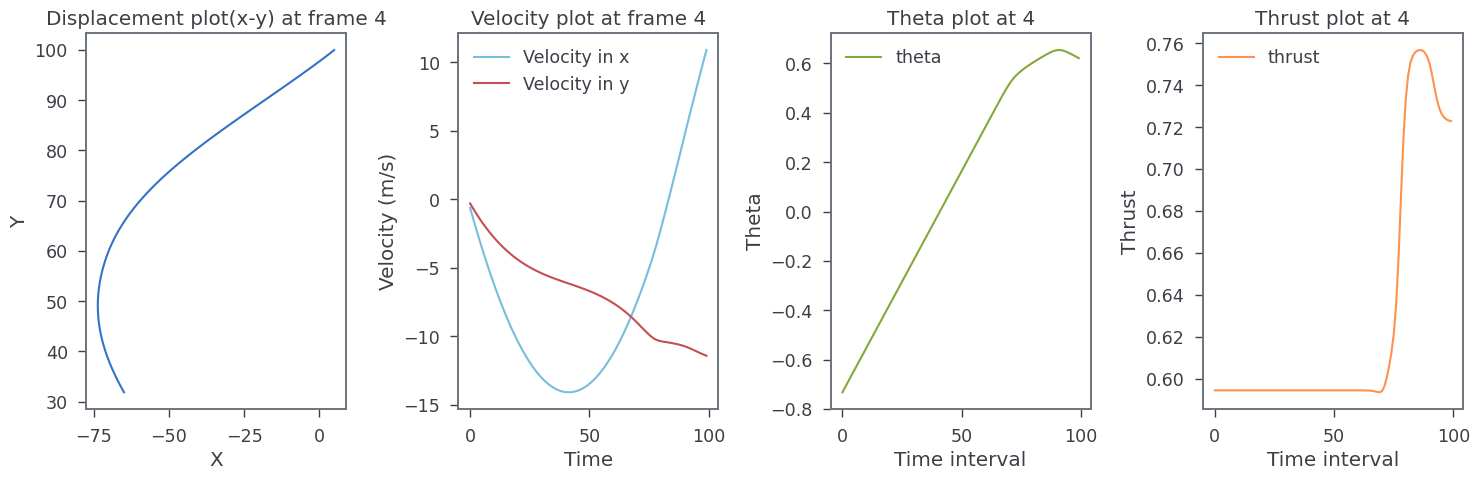

[6] loss: 2028.034


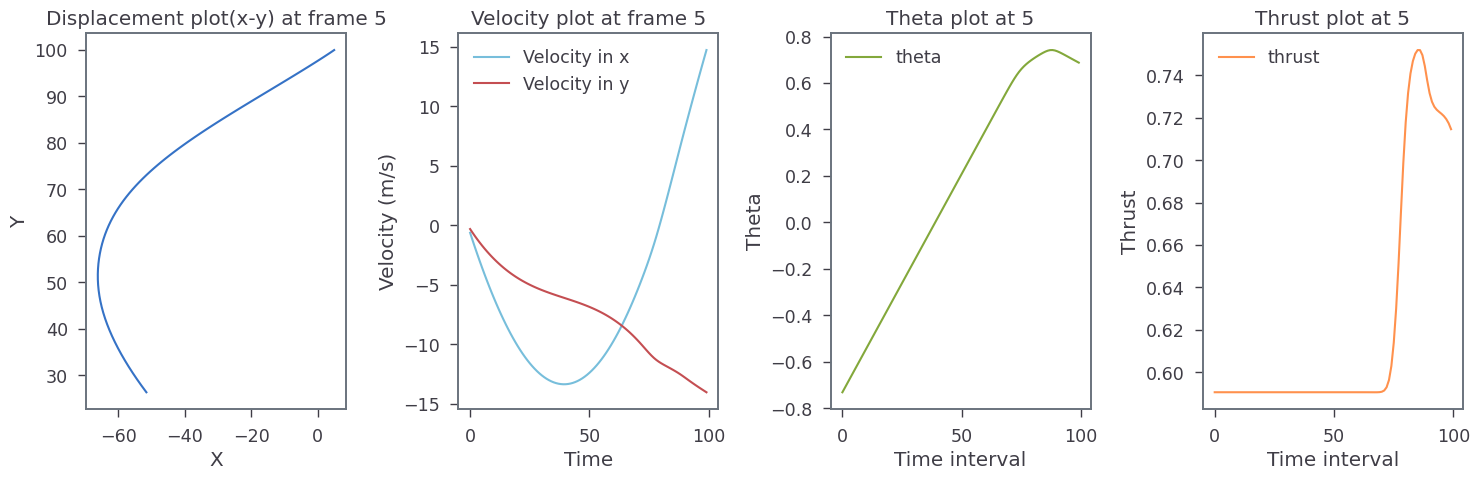

[7] loss: 1298.246


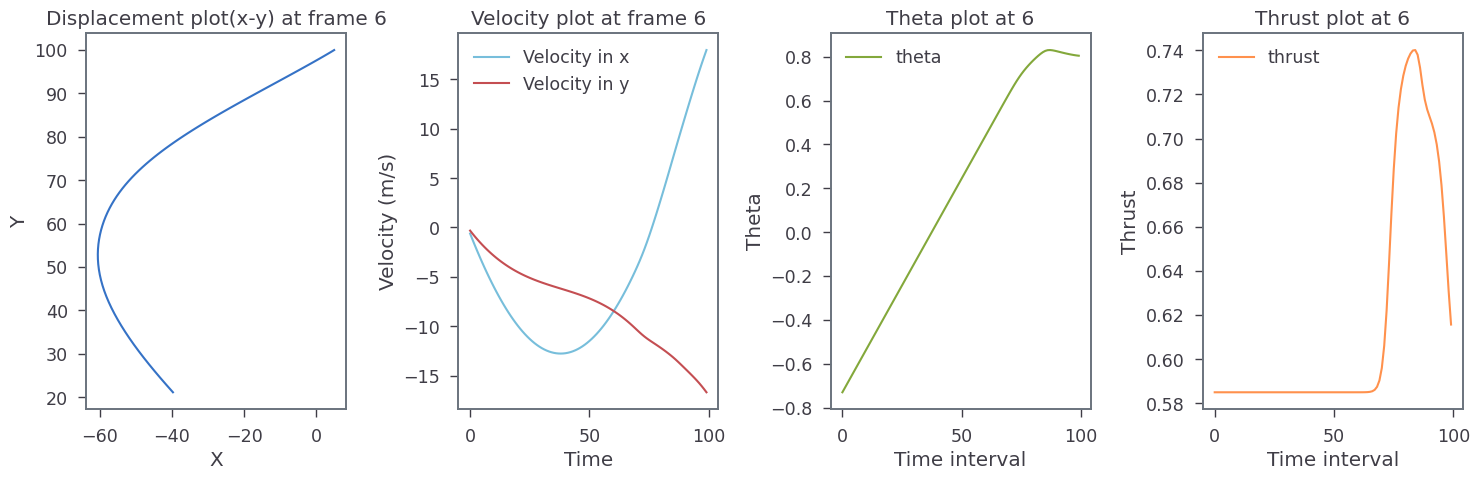

[8] loss: 860.188


[9] loss: 558.937


[10] loss: 349.788


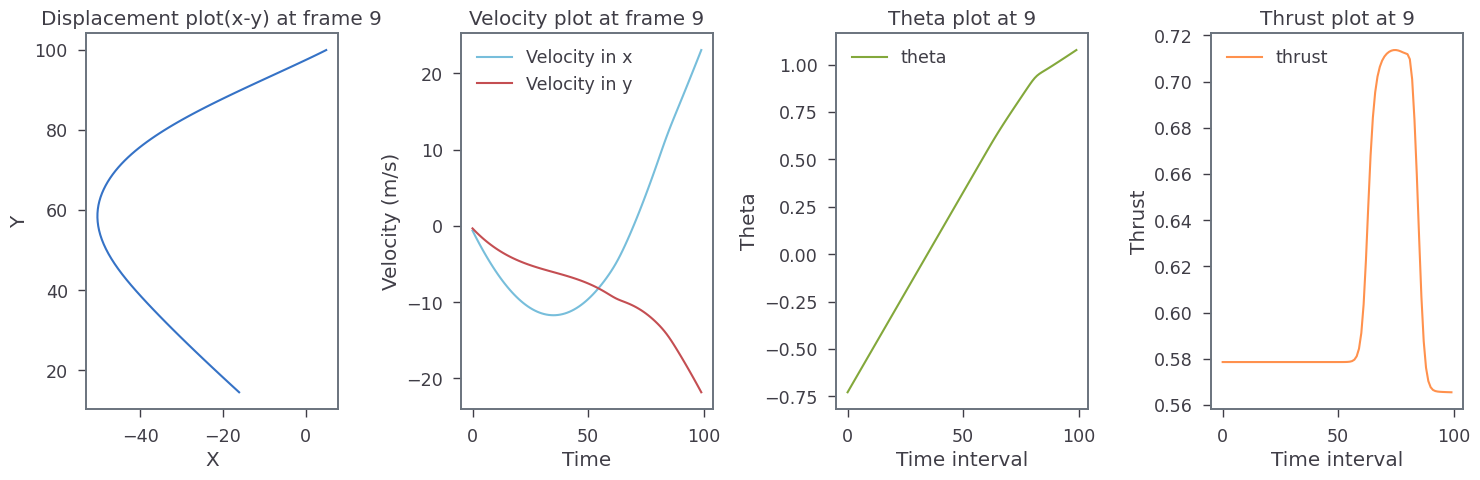

[11] loss: 204.868


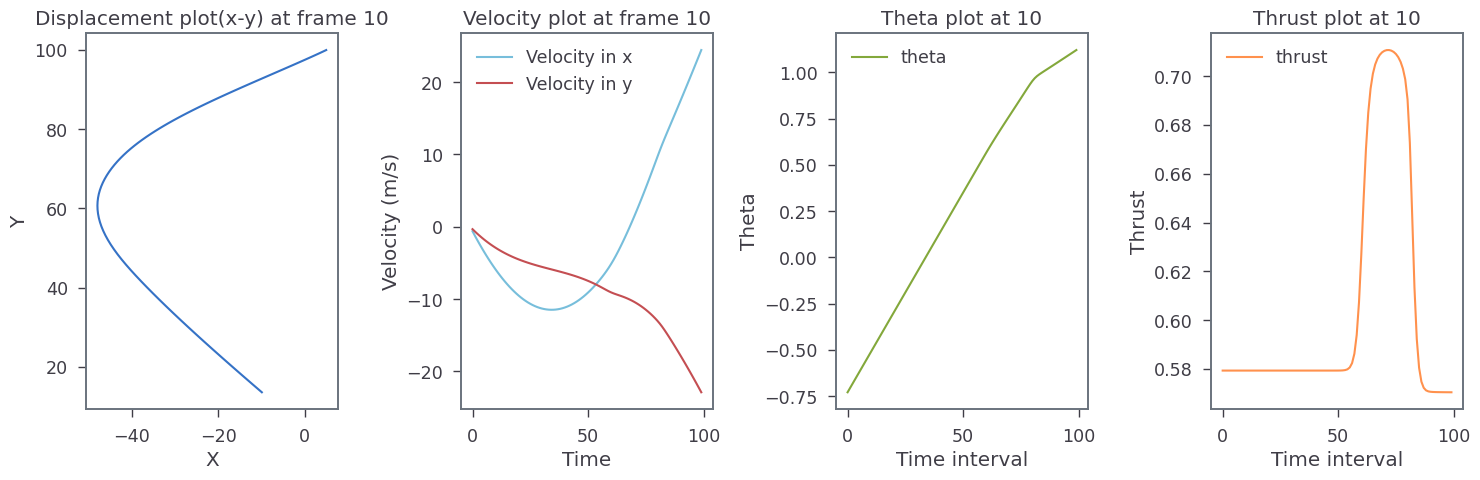

[12] loss: 115.763


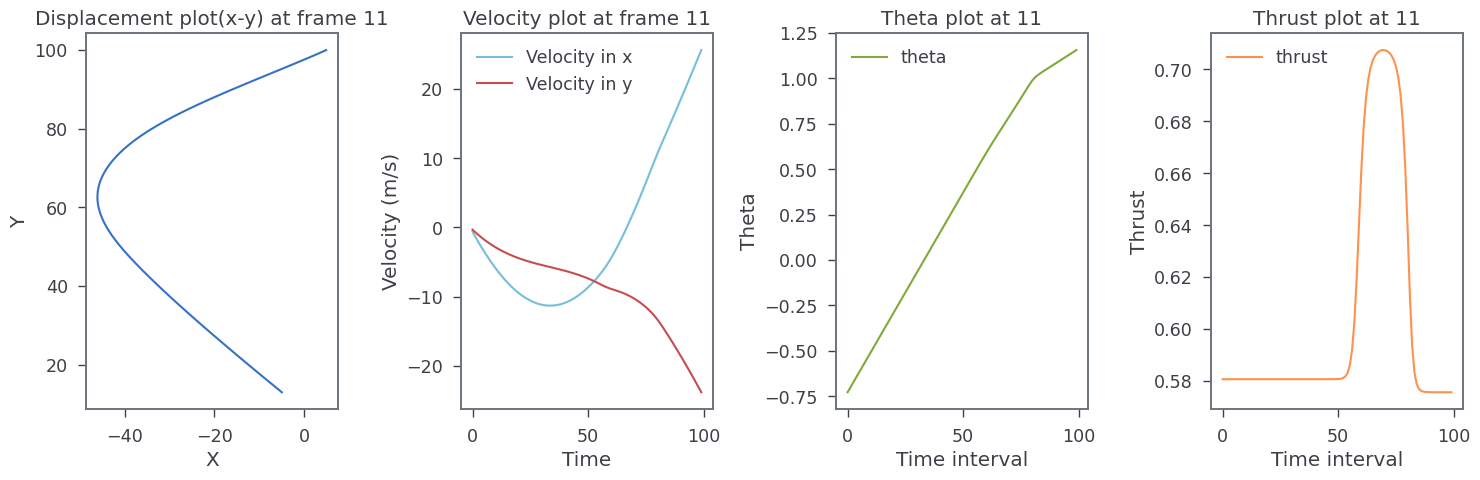

[13] loss: 67.241


[14] loss: 40.283


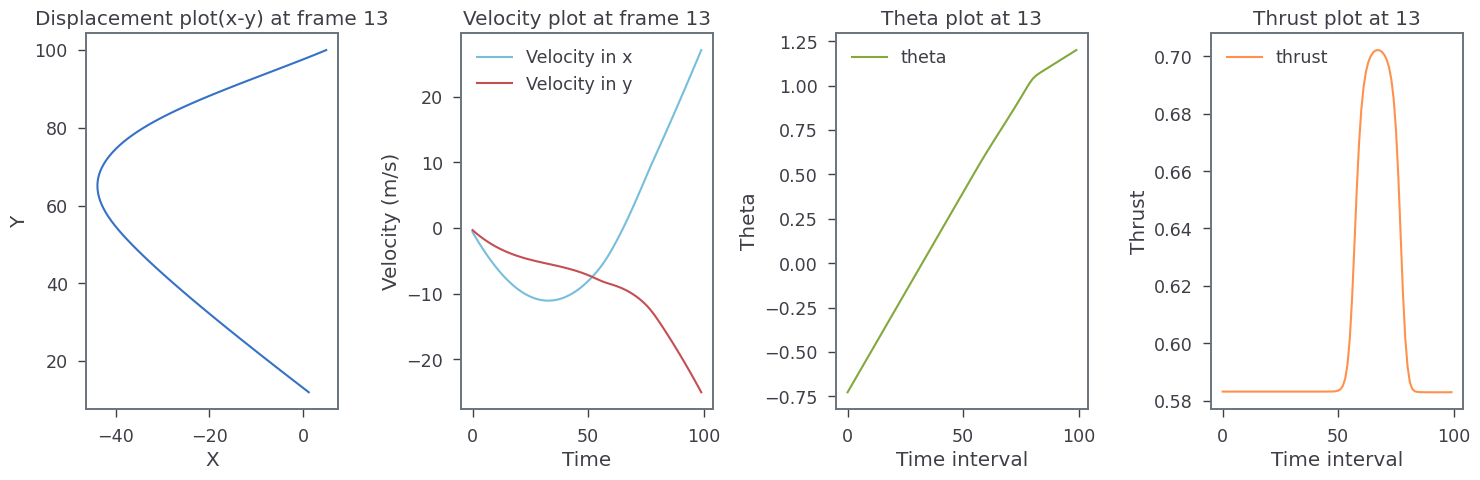

[15] loss: 24.696


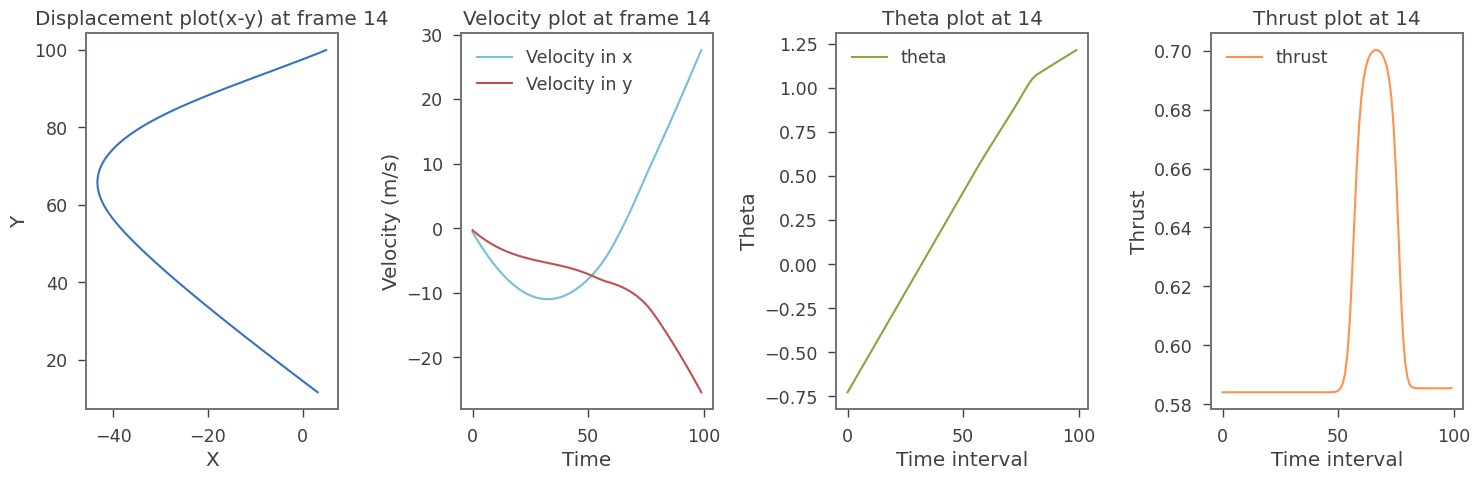

[16] loss: 15.356


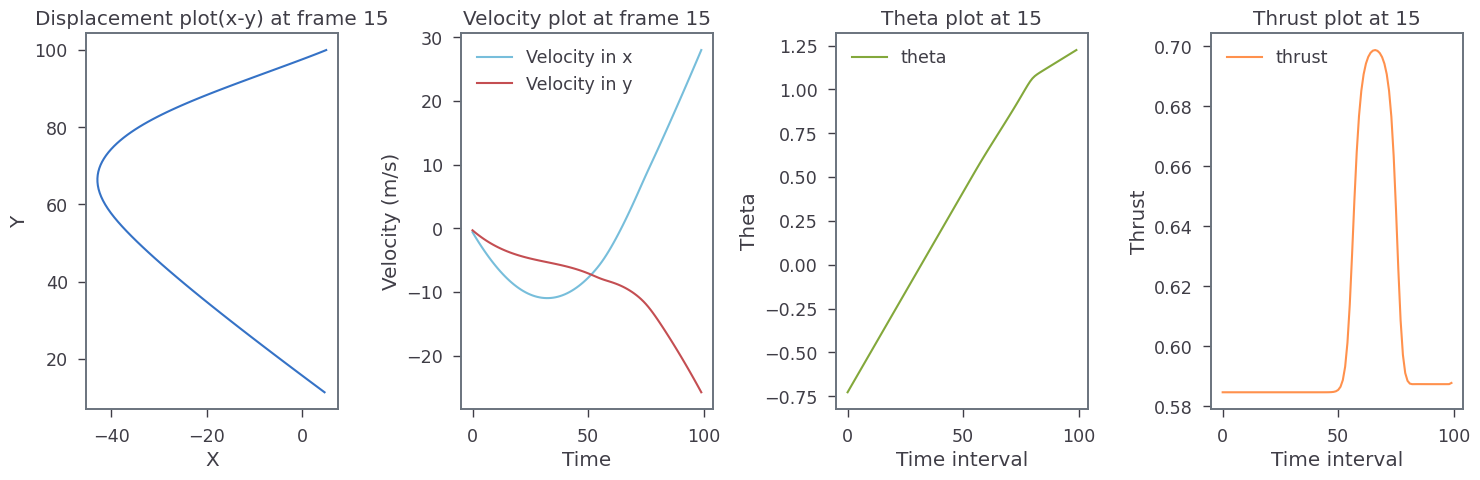

[17] loss: 9.581


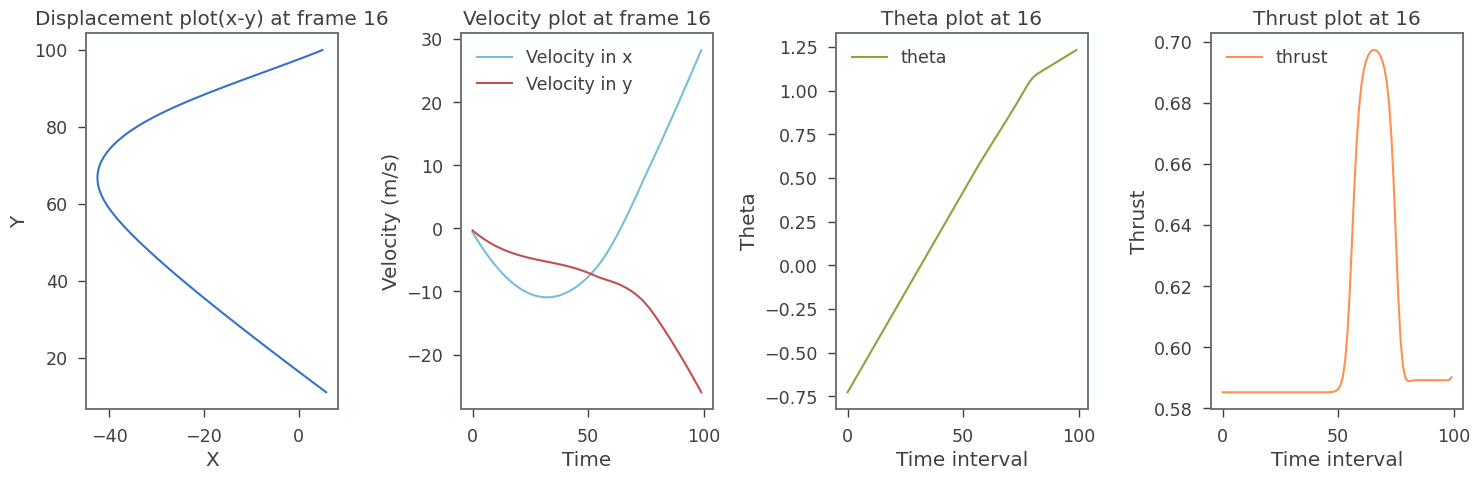

[18] loss: 5.957


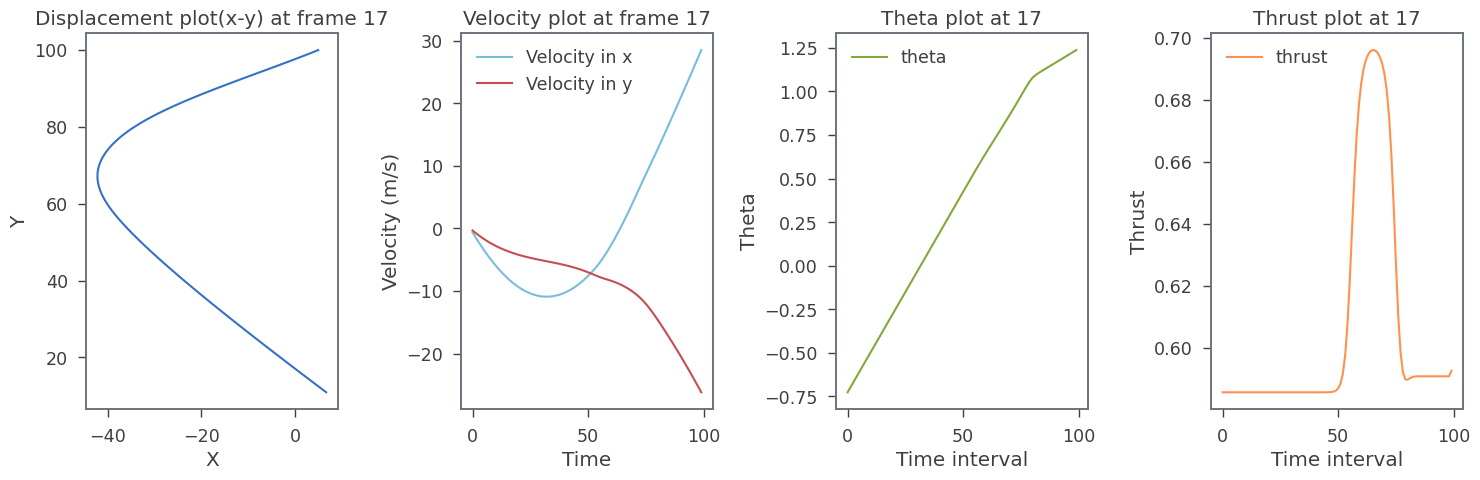

[19] loss: 3.694


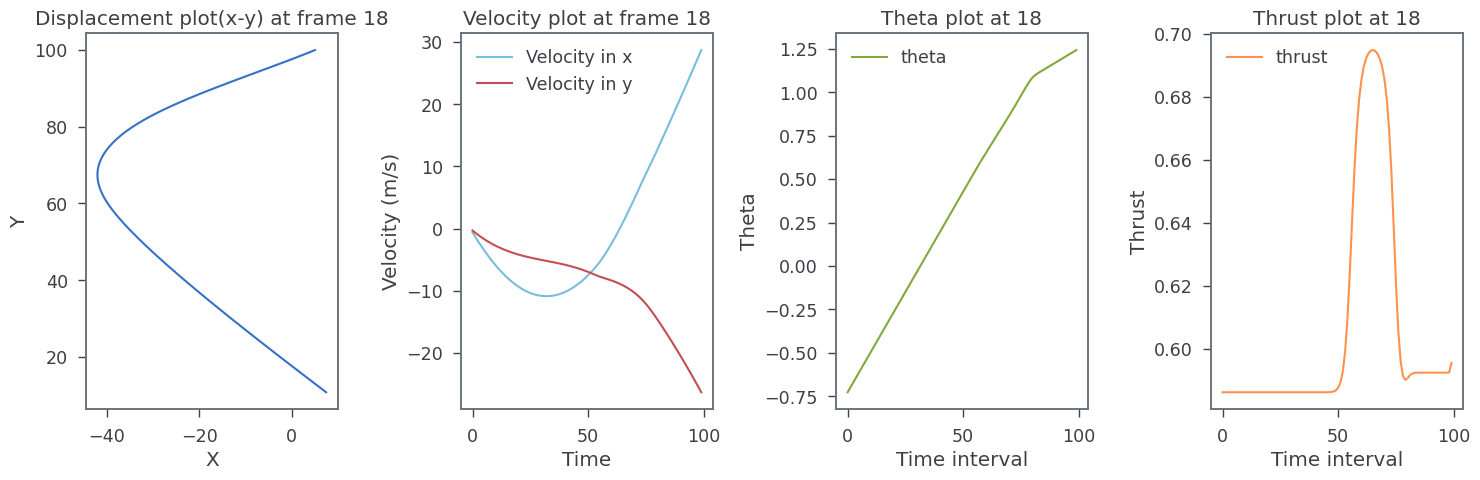

[20] loss: 2.293


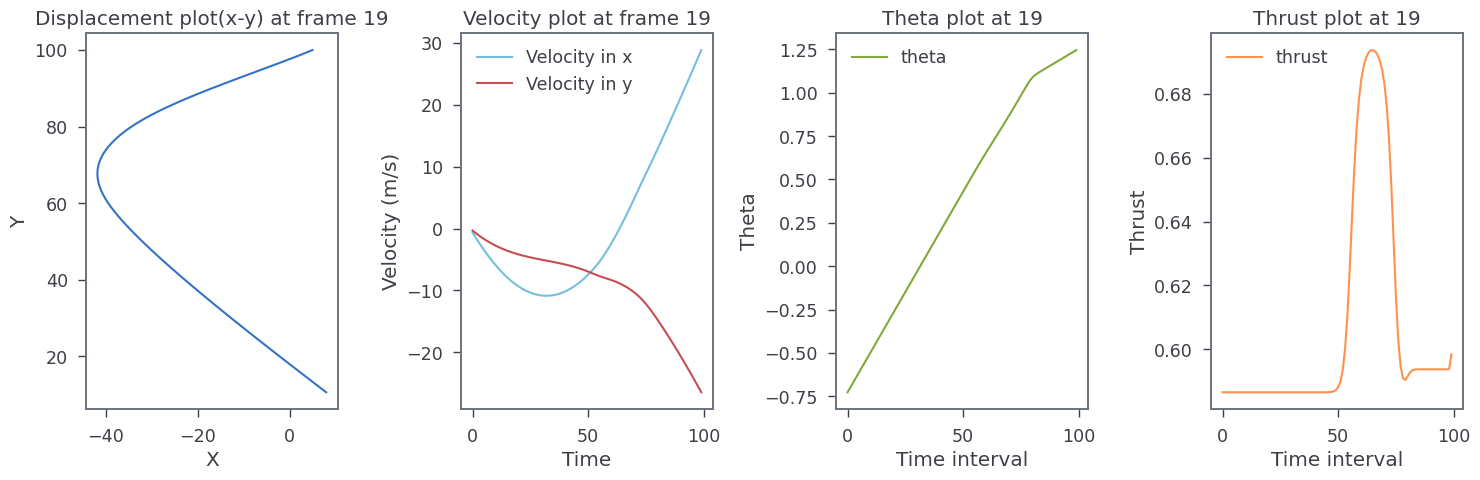

[21] loss: 1.430


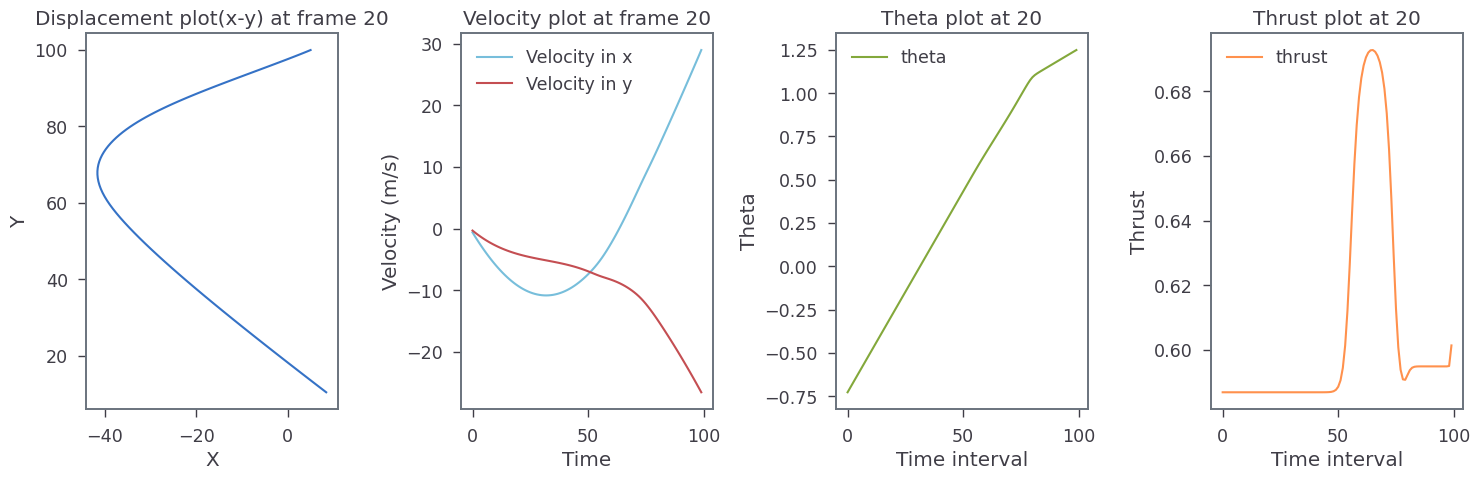

[22] loss: 0.897


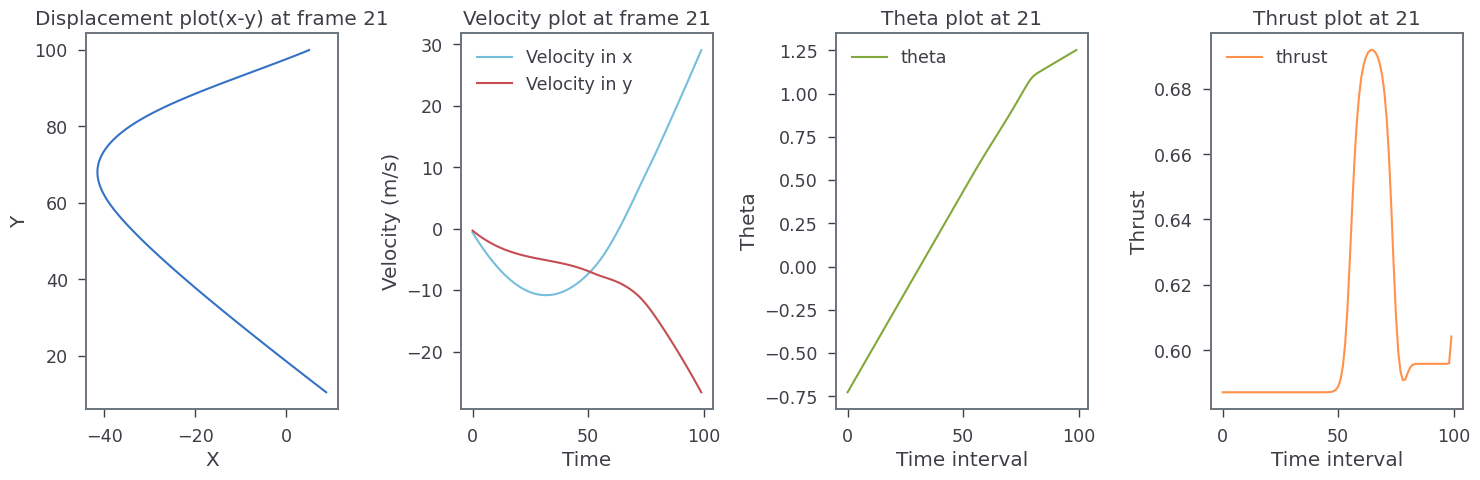

[23] loss: 0.565


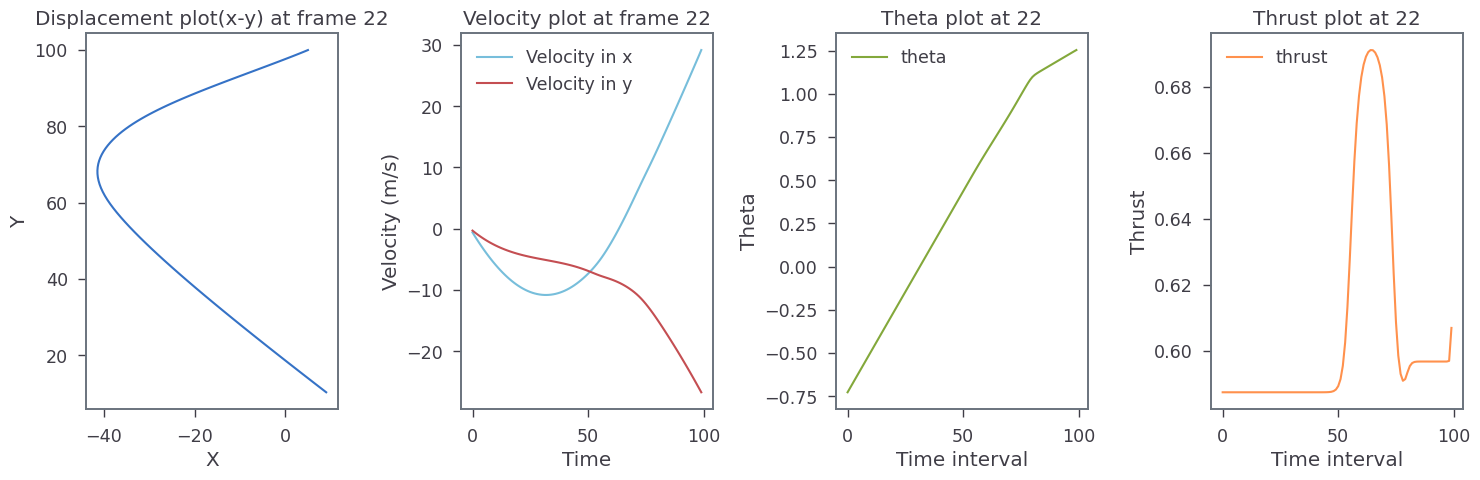

[24] loss: 0.356


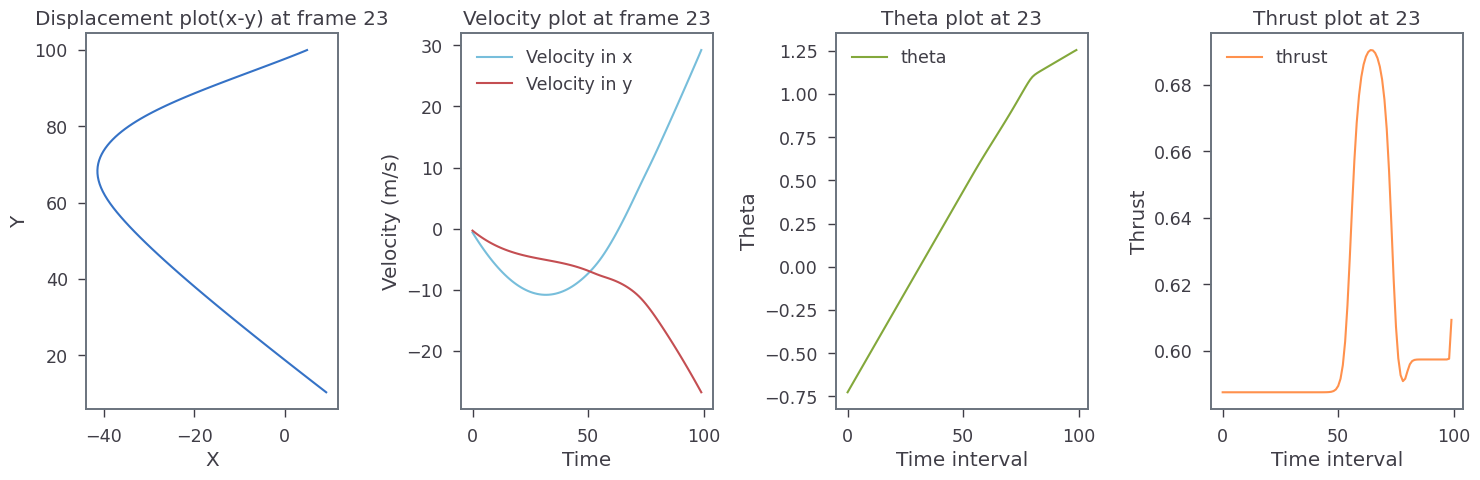

[25] loss: 0.225


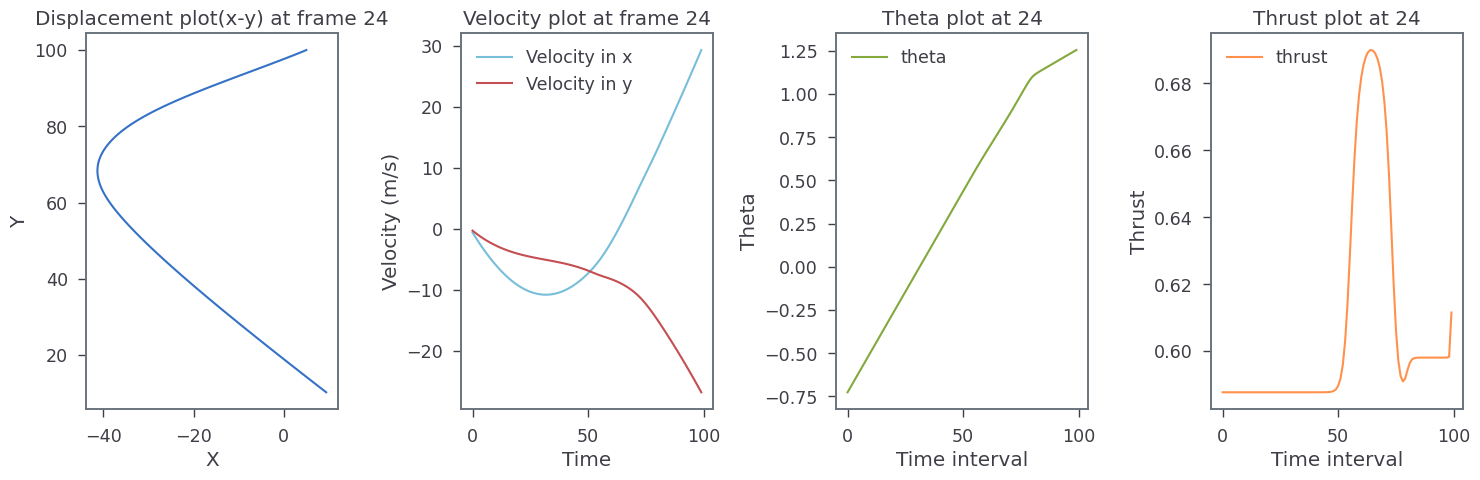

[26] loss: 0.142


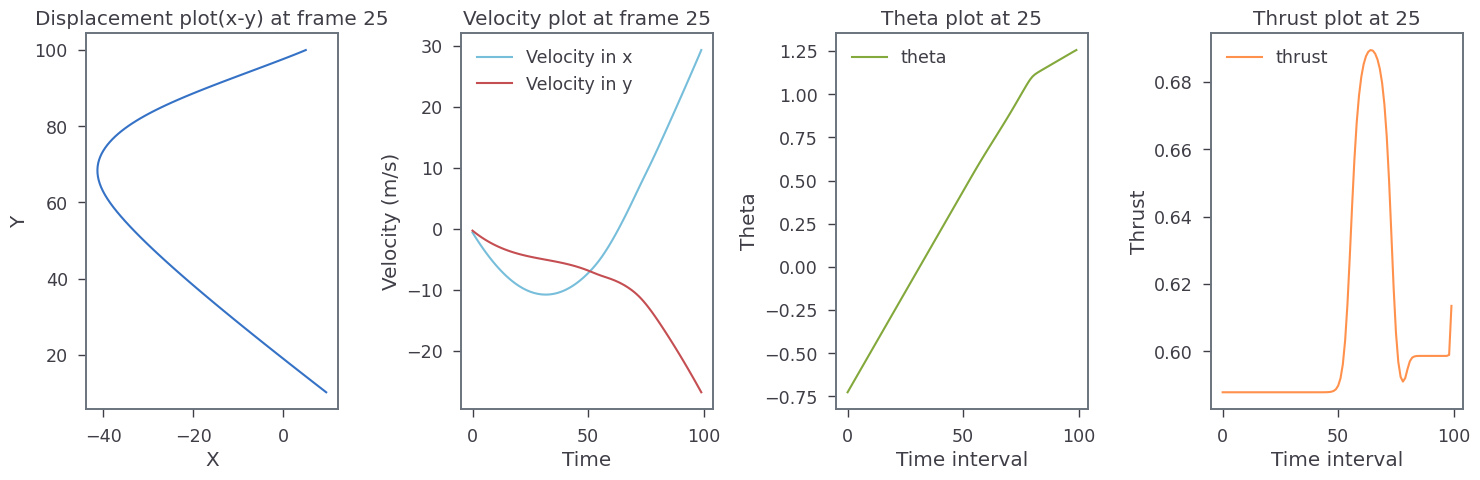

[27] loss: 0.090


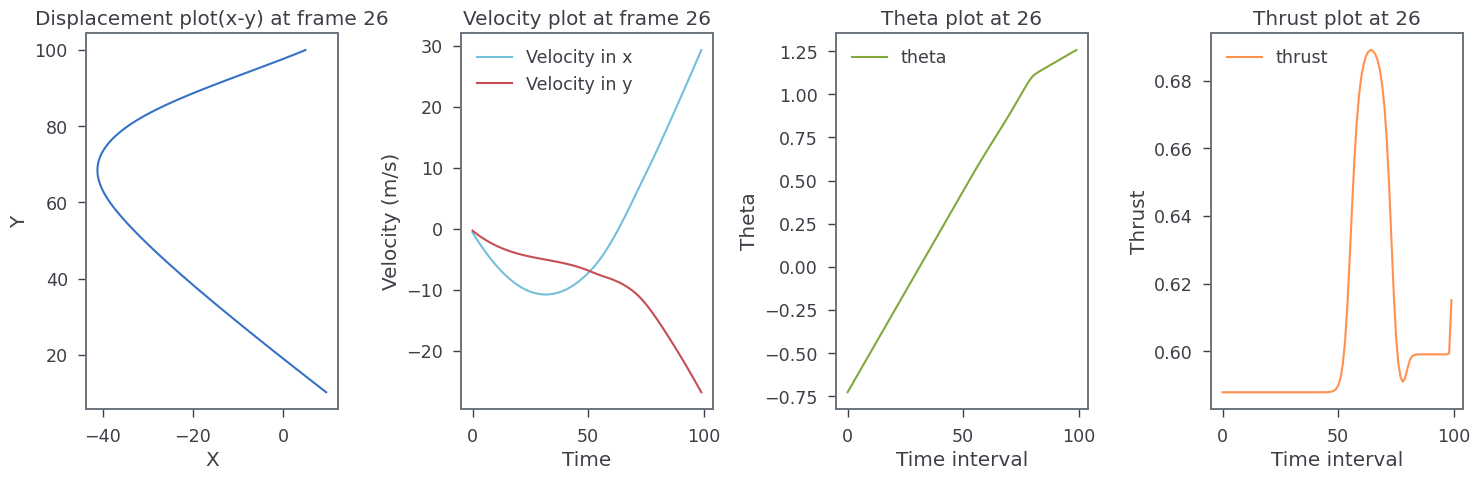

[28] loss: 0.057


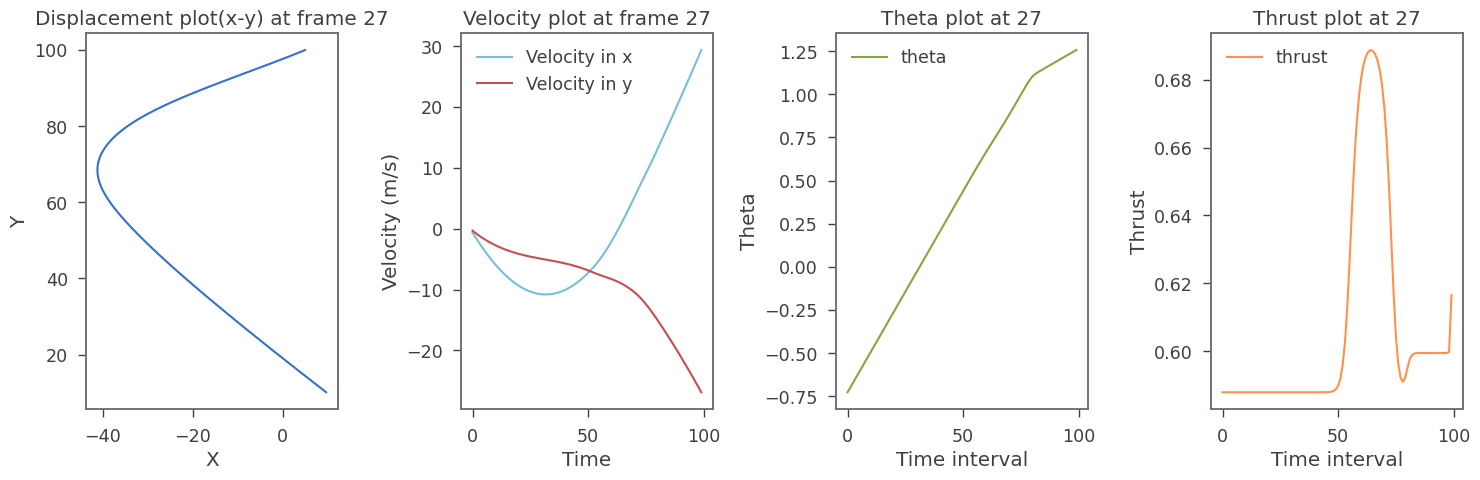

[29] loss: 0.036


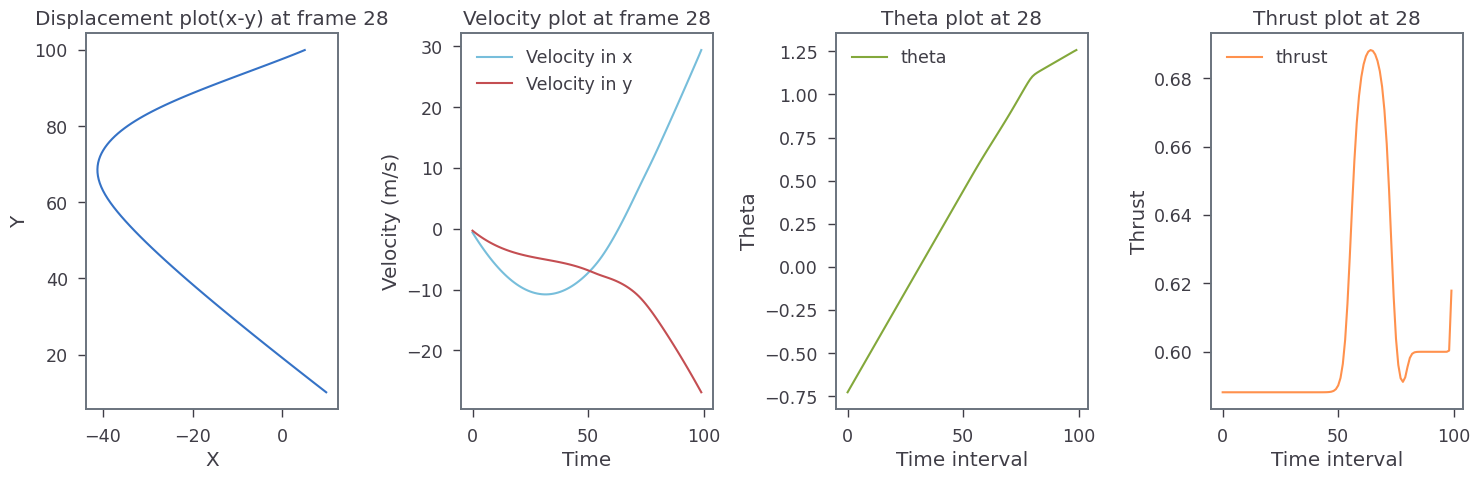

[30] loss: 0.023


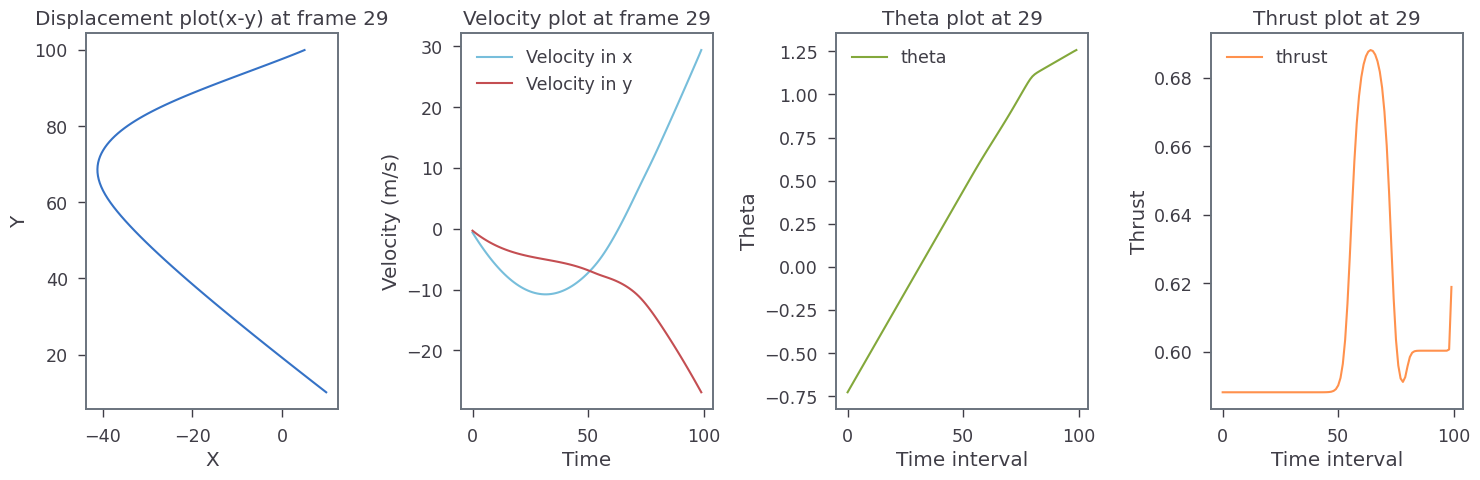

[31] loss: 0.015


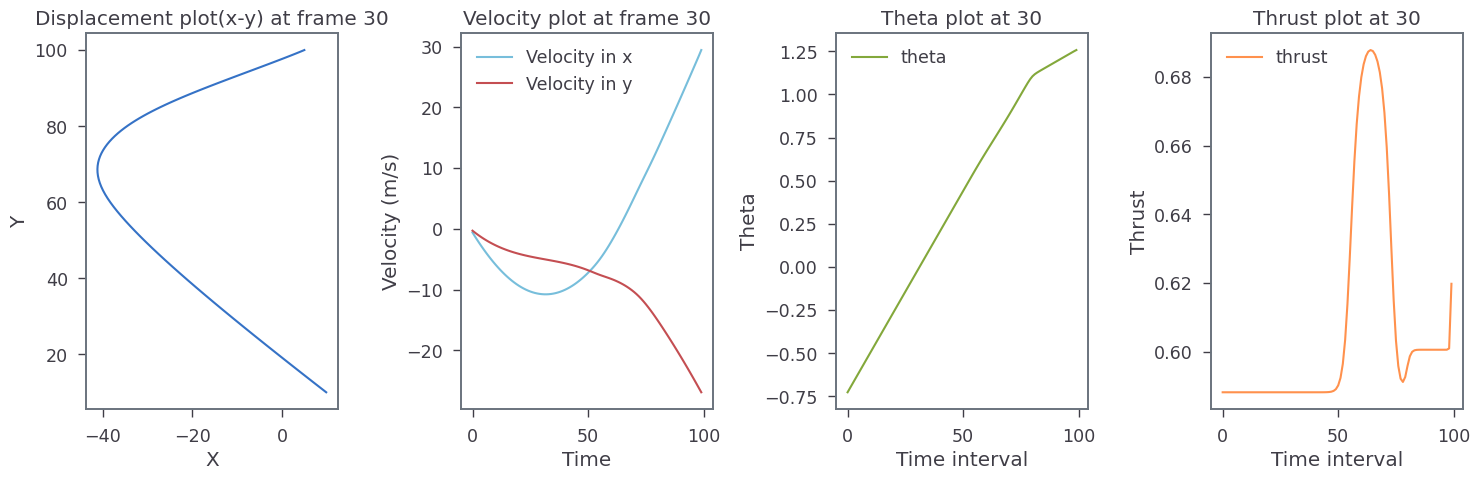

[32] loss: 0.009


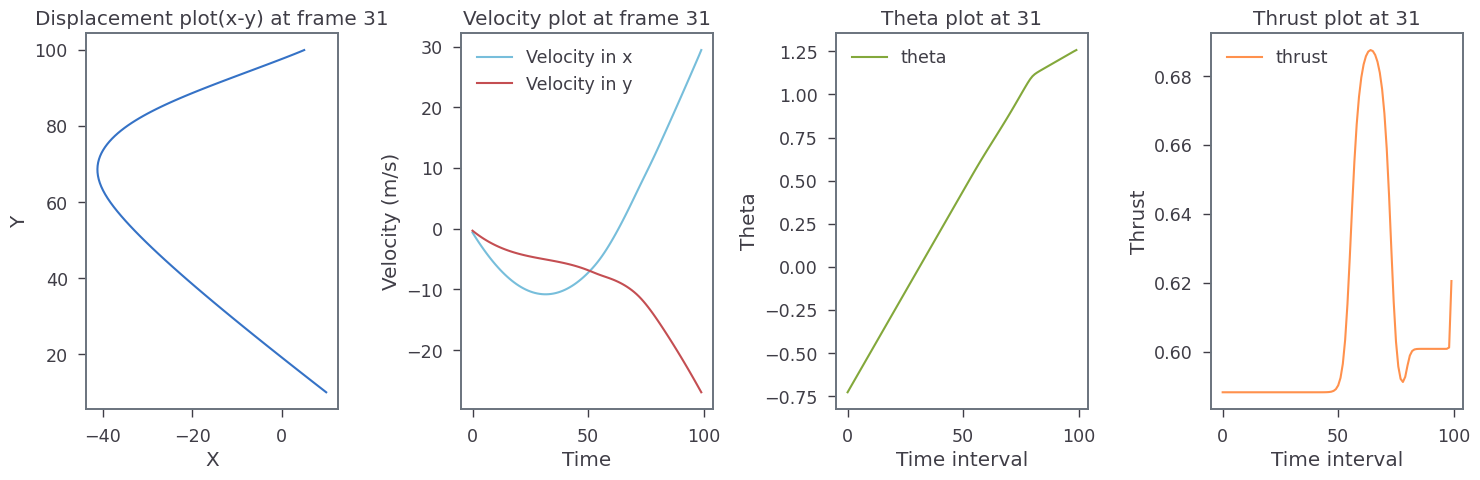

[33] loss: 0.006


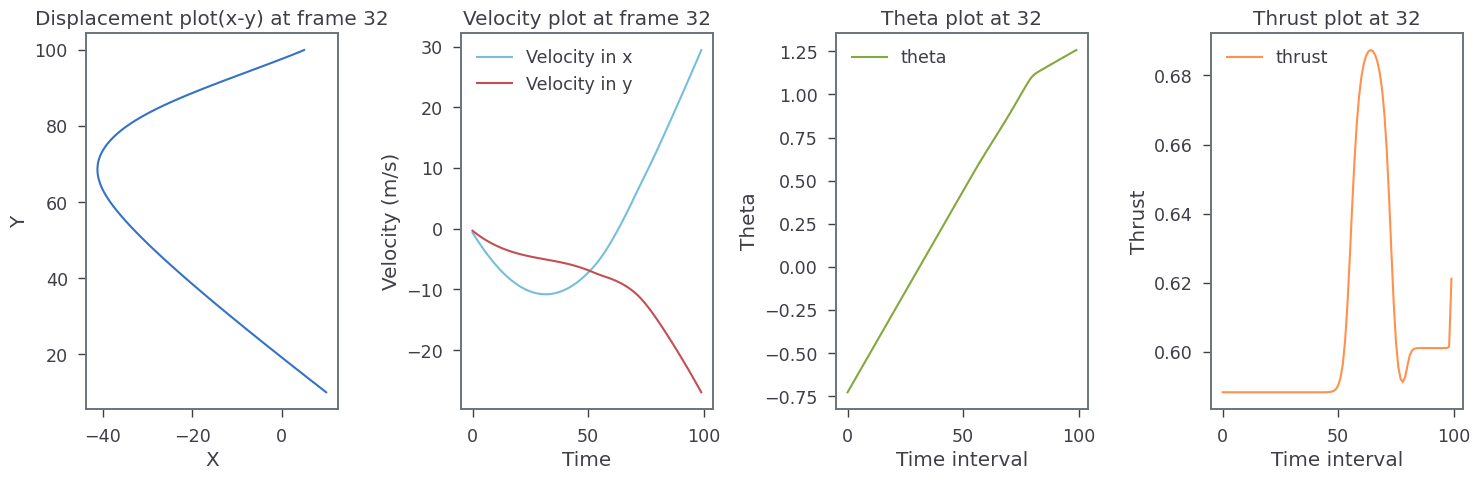

[34] loss: 0.004


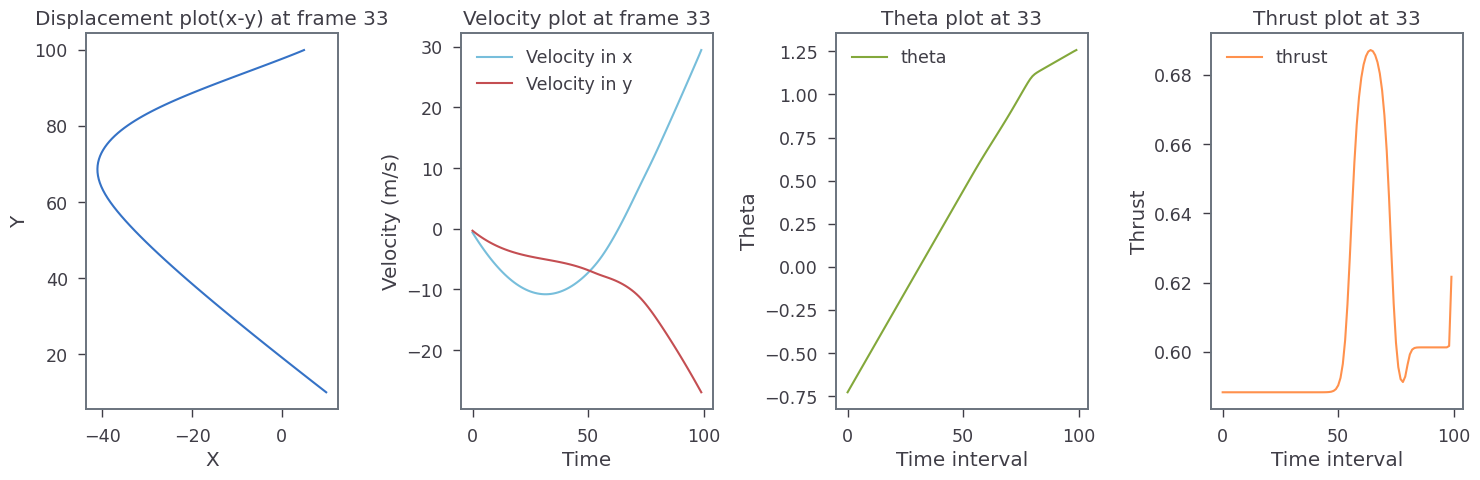

[35] loss: 0.002


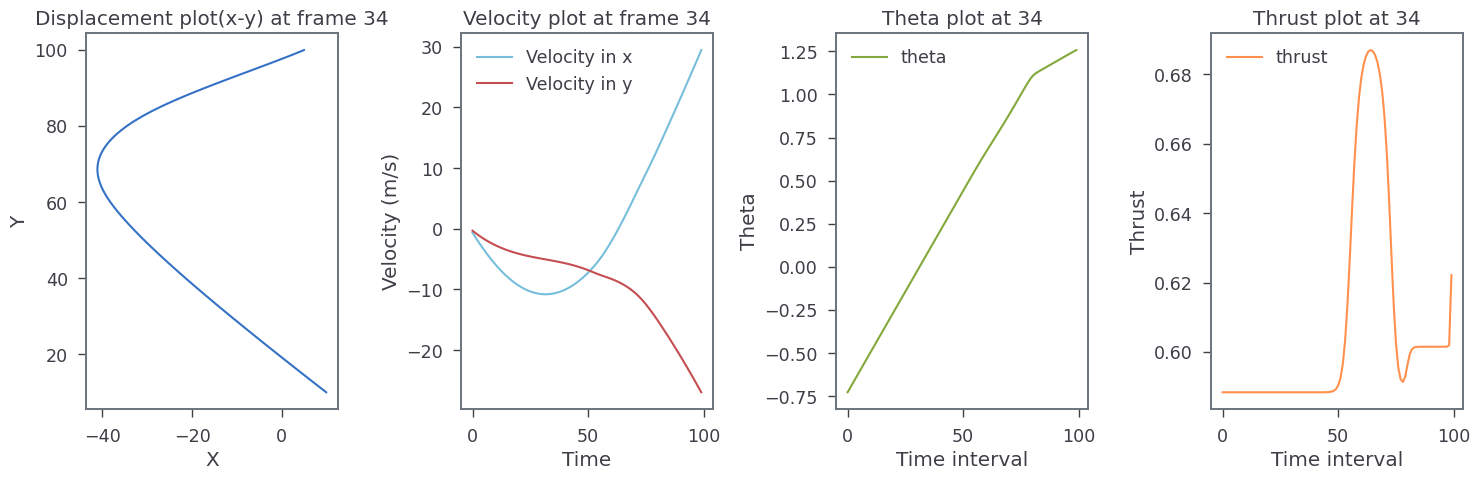

[36] loss: 0.001


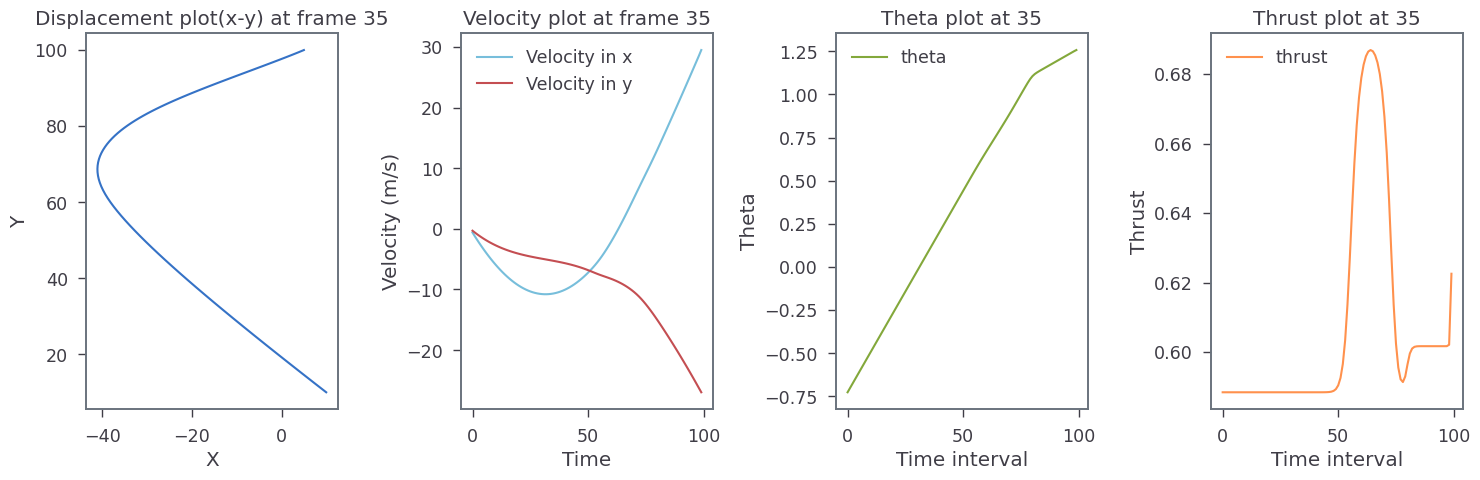

[37] loss: 0.001


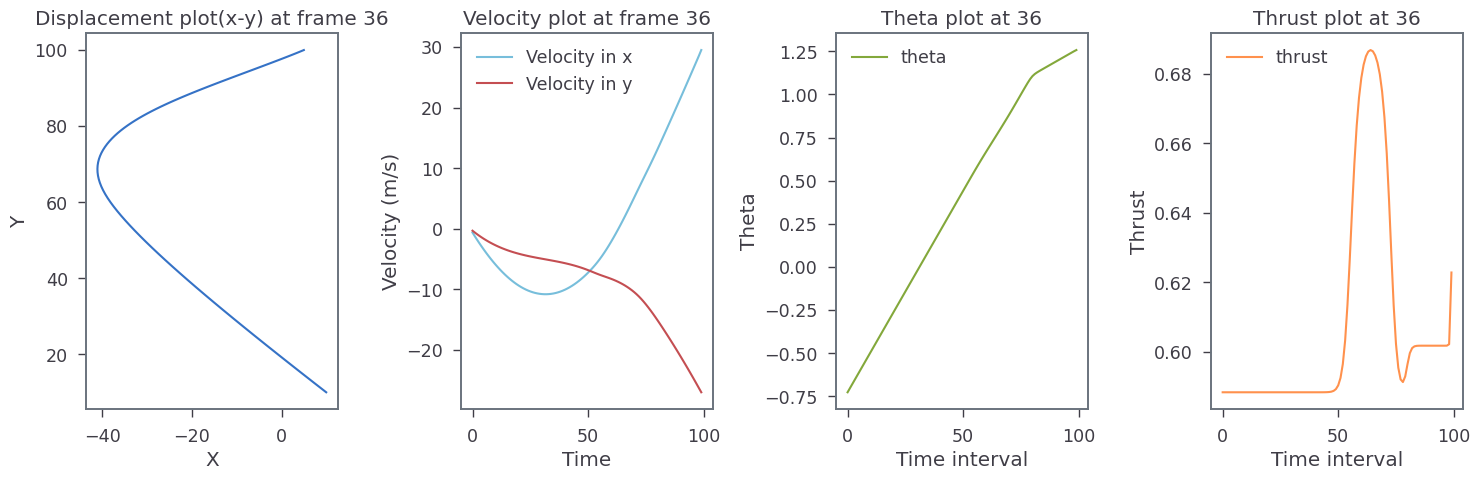

[38] loss: 0.001


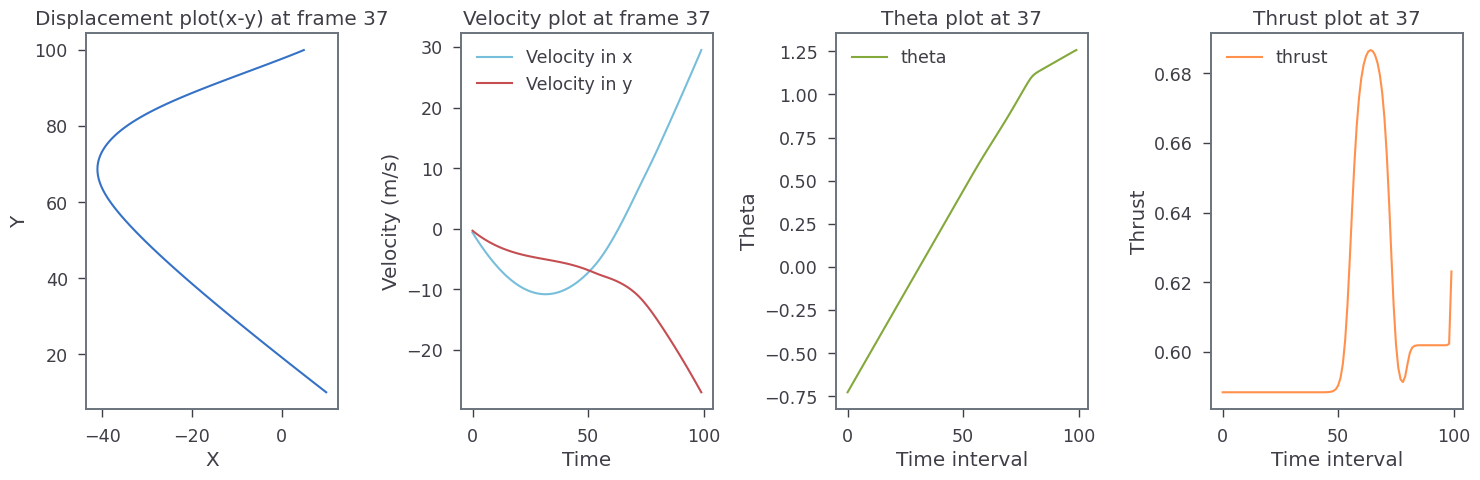

[39] loss: 0.000


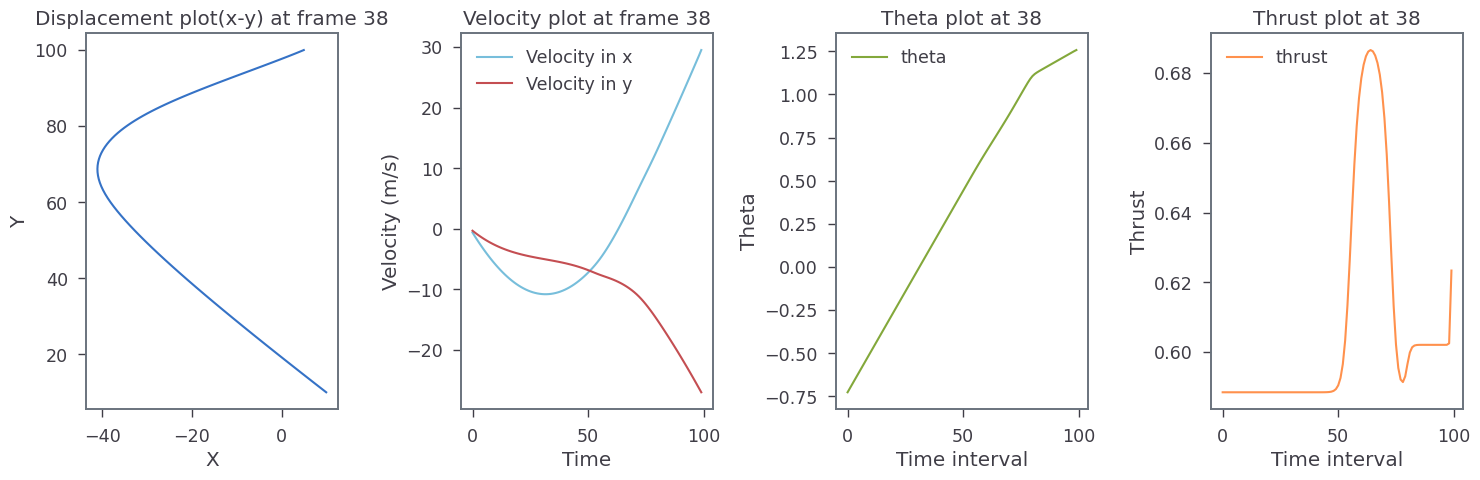

[40] loss: 0.013


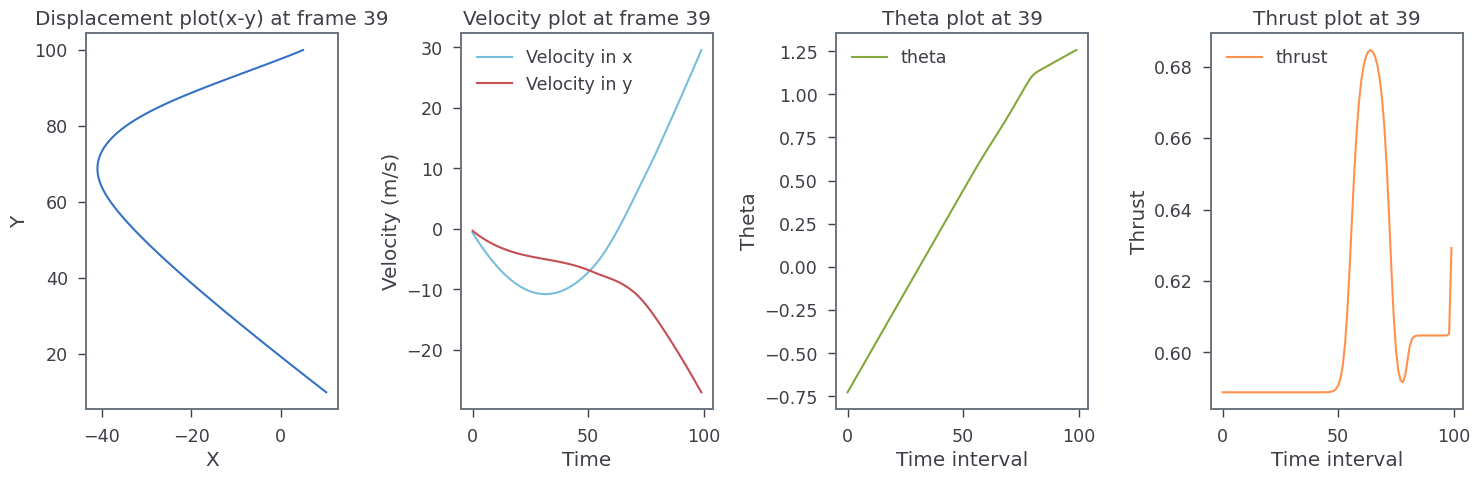

[41] loss: 0.009


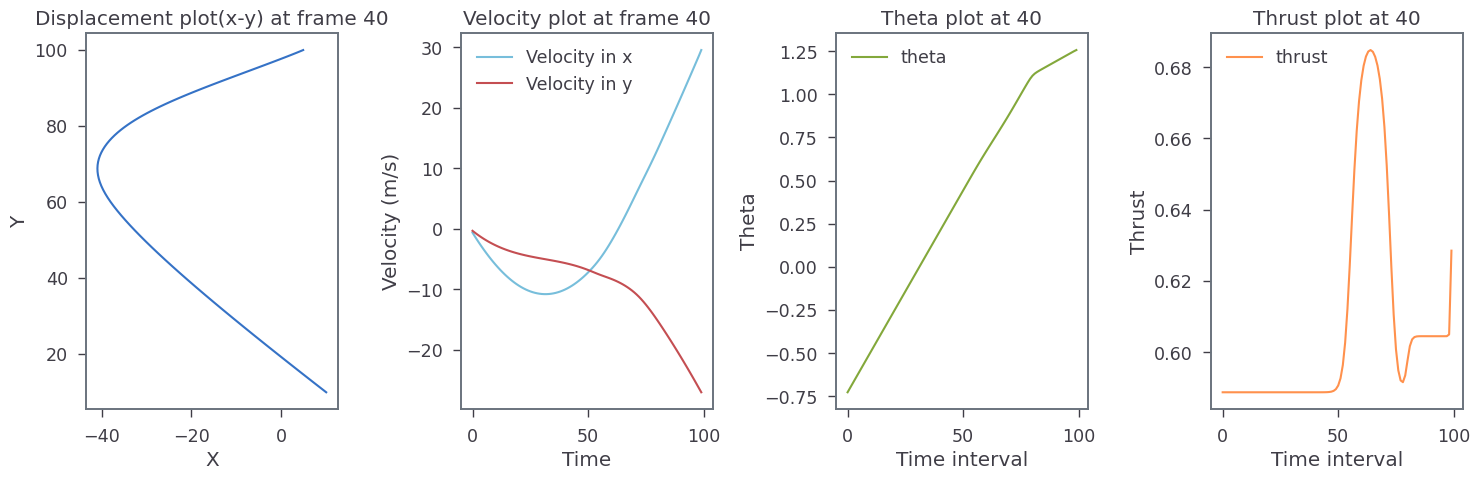

[42] loss: 0.006


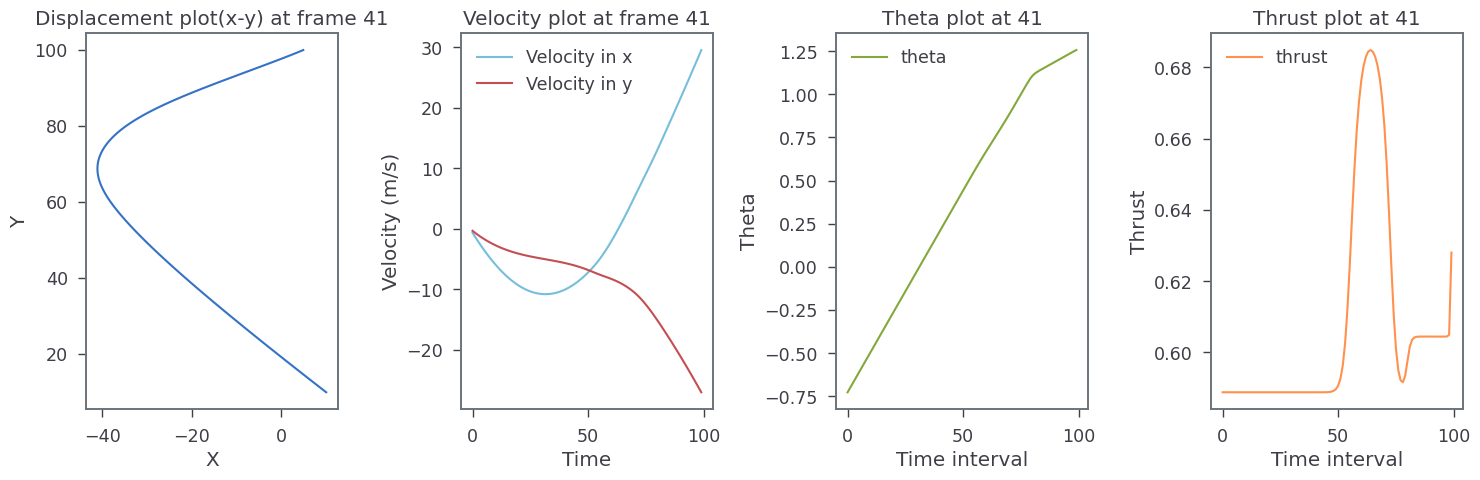

[43] loss: 0.004


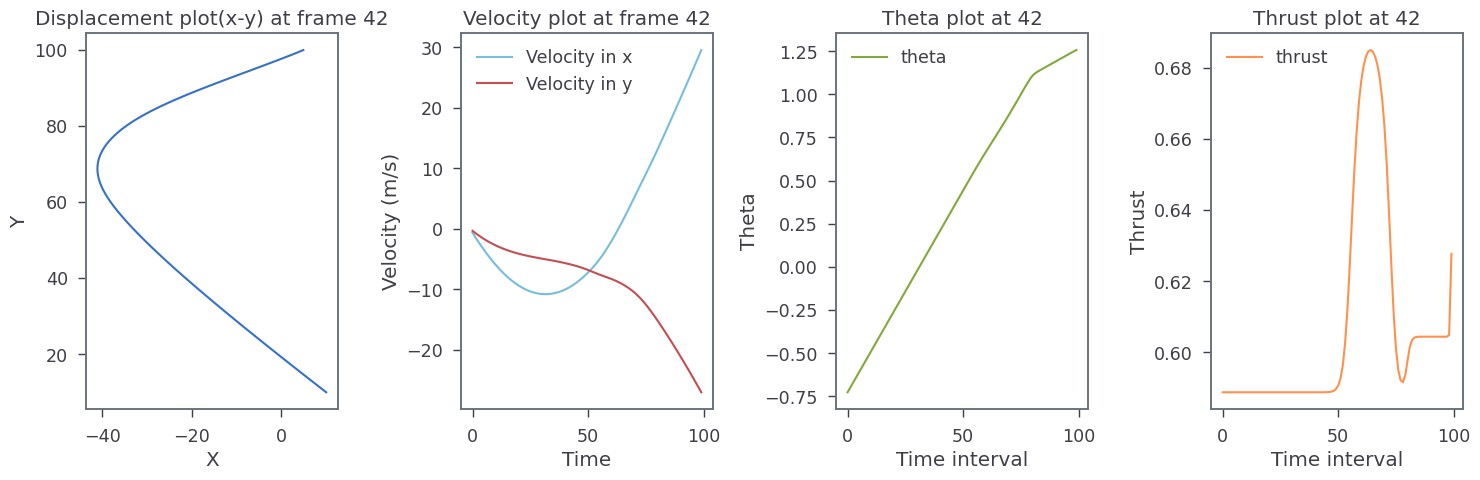

[44] loss: 0.003


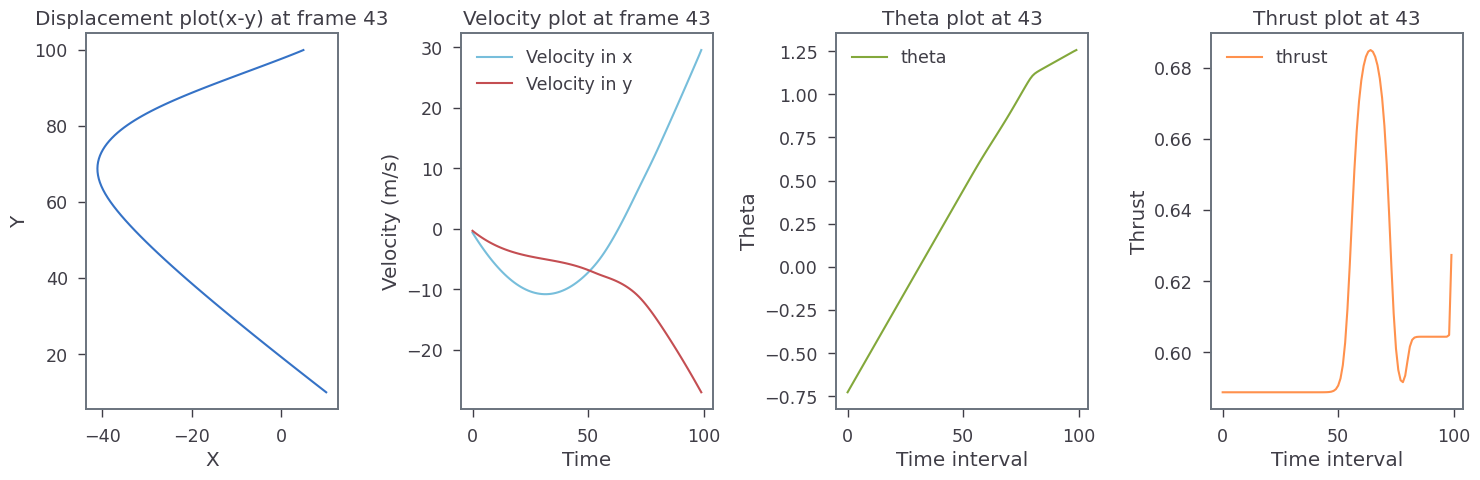

[45] loss: 0.002


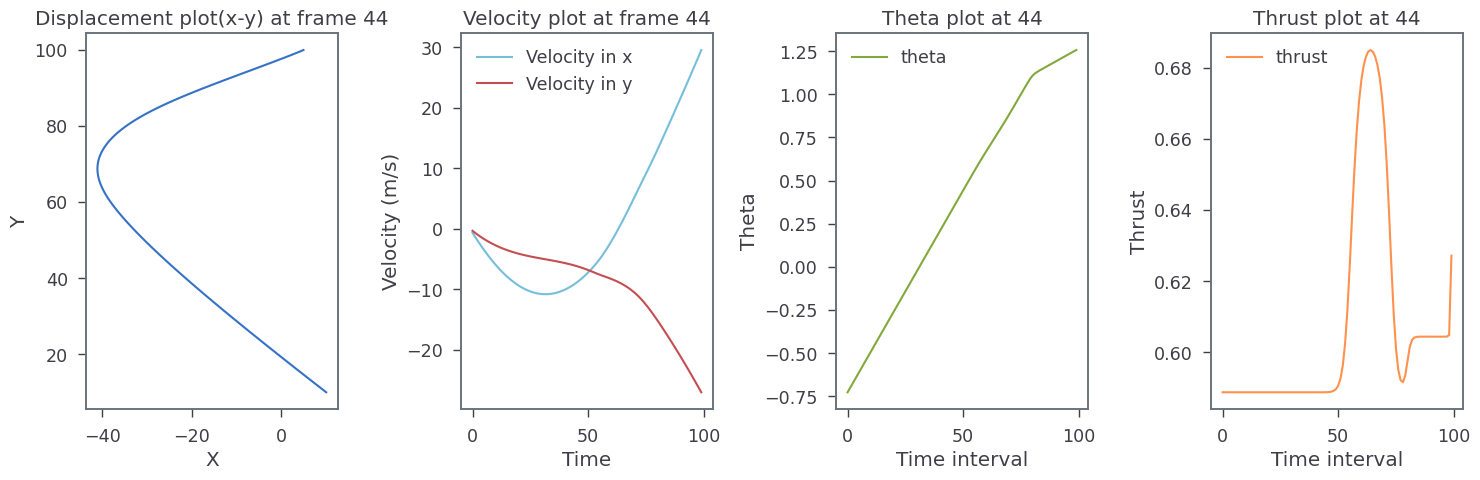

[46] loss: 0.001


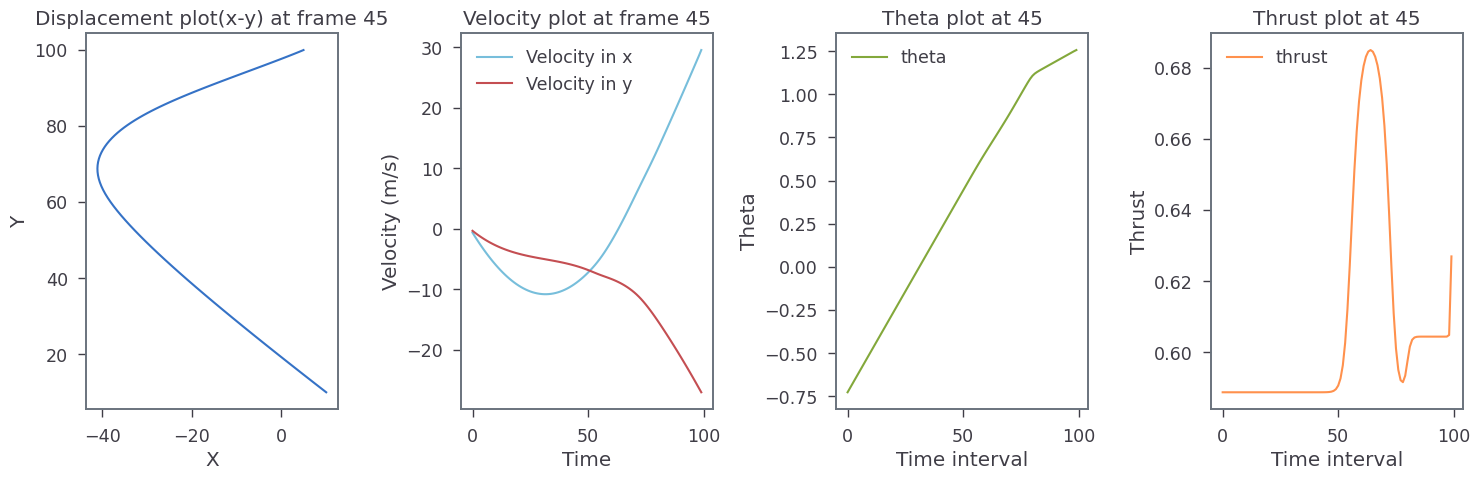

[47] loss: 0.001


[48] loss: 0.000


[49] loss: 0.000


[50] loss: 0.000


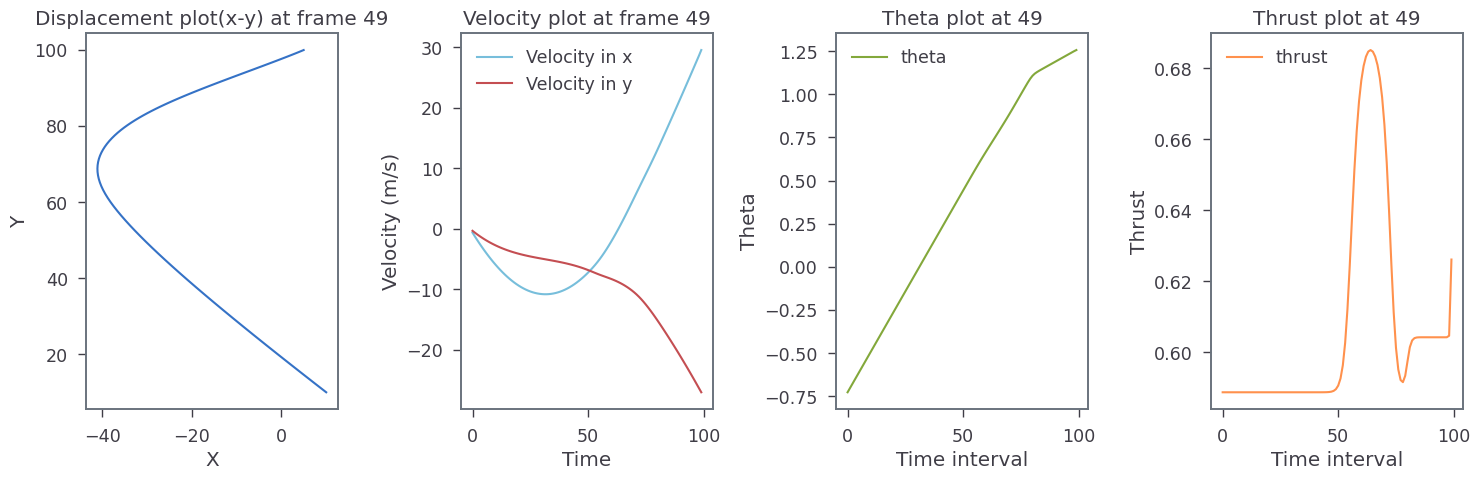

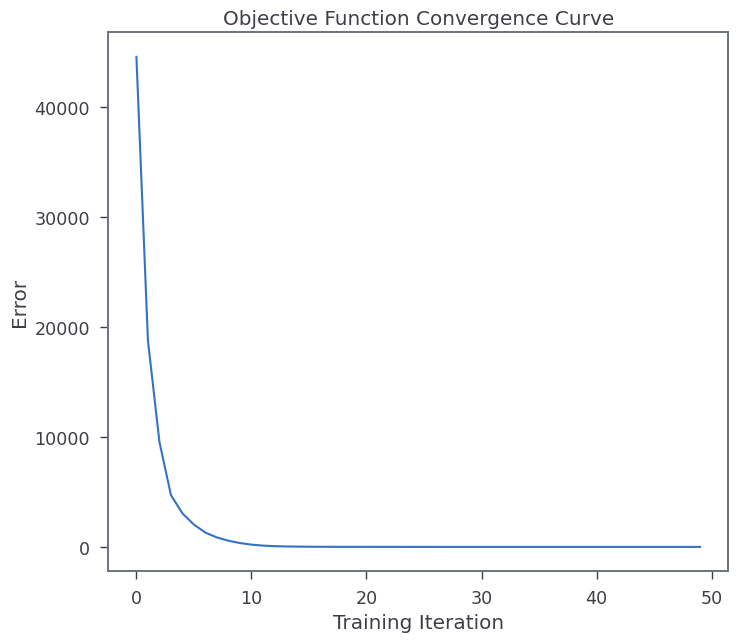

Generating Animation


IntProgress(value=0, max=101)

(100, 5) (100, 2)


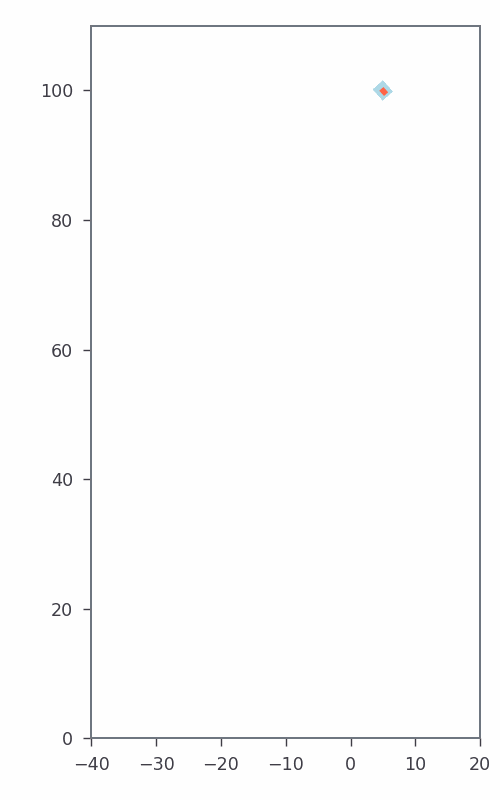

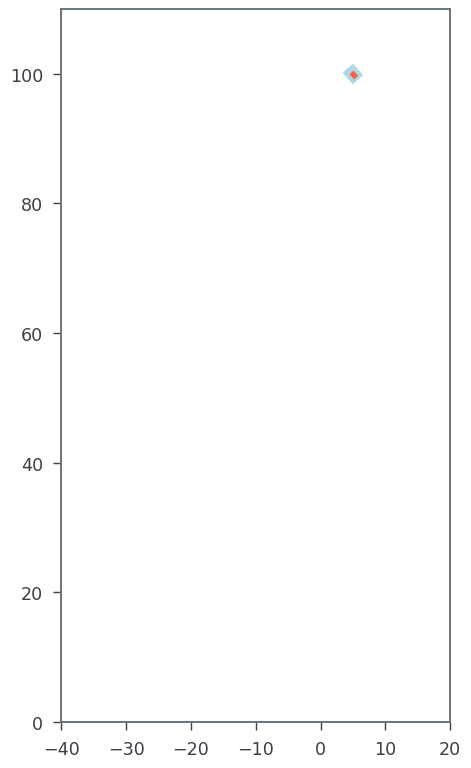

In [ ]:
T = 100  # number of time steps of the simulation
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()
c = Controller(dim_input, dim_hidden, dim_output)
s = Simulation(c, d, T)
o = Optimize(s)
o.train(50)  # training with number of epochs (gradient descent steps)
Image(filename="Helicopter_hover.gif")

## 3. Analysis
Problem Formulation and Target Altitude: One crucial consideration is that the target altitude of 10 meters was set as the goal for the helicopter's descent and hovering. While this was successfully achieved in the program, it's essential to emphasize that problem formulation and task objectives play a significant role in control optimization. Depending on the application, different altitude targets and control objectives may be required. For example, tasks that demand precision in altitude control may have different requirements compared to tasks that prioritize speed.

Hyperparameter Tuning for Optimization Algorithm: The choice of the L-BFGS optimization algorithm proved effective in minimizing the control error and achieving the desired altitude. However, the choice of hyperparameters, such as the learning rate and optimization parameters for L-BFGS, can significantly impact convergence speed and performance. It would be valuable to explore hyperparameter tuning techniques, like grid search or random search, to find optimal hyperparameter values that could potentially lead to faster convergence.

Tensor Operations and Computational Efficiency: Tensor operations are fundamental in deep learning and optimization, and they play a crucial role in this program. To ensure computational efficiency and reduce the risk of errors, careful attention to tensor dimensions, shapes, and operations is necessary. Debugging and testing of tensor operations, especially when dealing with complex neural network architectures and dynamic systems, can be a time-consuming task. Robust debugging practices and code reviews are essential to catch and rectify coding issues efficiently.

Batch Processing for Versatility: The program currently optimizes the controller for a single initial state, which limits its versatility. An important lesson learned is the potential for enhancing the program's adaptability by optimizing the controller for a batch of initial states. This could extend the program's applicability to a broader range of scenarios. However, implementing batch processing might require adjustments to the code, specifically in the loss computation and optimization phases.

Loss Term Weighting for Control Objectives: While the program achieved the desired altitude, fine-tuning the weights associated with different loss terms was mentioned as a common practice in control design. This can be crucial for prioritizing specific control objectives. For example, if precise altitude control is more critical than minimizing horizontal displacement, it may be necessary to assign higher weights to the altitude-related loss terms. Exploring various weight configurations could help fine-tune the controller for different application scenarios.

In summary, the successful achievement of the helicopter's descent and hovering at the specified target altitude is a significant milestone. However, several areas for improvement and exploration exist, including problem formulation, hyperparameter tuning, code optimization, batch processing, and fine-tuning of loss term weights. Addressing these aspects can further enhance the versatility and performance of the control system in real-world applications.